* https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
* https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
* https://github.com/soumith/ganhacks

In [1]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.utils import save_image
#########################
seed = 2
cuda = torch.cuda.is_available()
# torch.cuda.empty_cache()
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic=True
#########################
snapshot_folder = 'simpson_weights_model2'
test_folder = 'simpson_test2'
batch_size = 32 # lower BS can be beneficial
image_size = 128
init_lr = 0.0002
latent_dim = 100
low_dim_rep = 8
decay_rate = 0.96
EPSILON = 0.00005

device = torch.device('cuda' if cuda else 'cpu')
assert device.type == 'cuda'

In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

### Loading the data

In [3]:
def get_data(size= 32):
    train_data_dir = 'simpson_dataset'

    train_tfms = transforms.Compose([
                                     transforms.Resize((size, size)),
                                     transforms.RandomHorizontalFlip(p=0.5),
#                                      transforms.RandomRotation(degrees=10),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                 ])
    
    train_set = datasets.ImageFolder(train_data_dir, transform= train_tfms)
    train_loader = DataLoader(train_set,batch_size = batch_size, shuffle= True, num_workers = 8)
  
    return train_loader 

In [4]:
train_loader= get_data(image_size)
num_class = len(train_loader.dataset.classes)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  9888
number of batches:  309


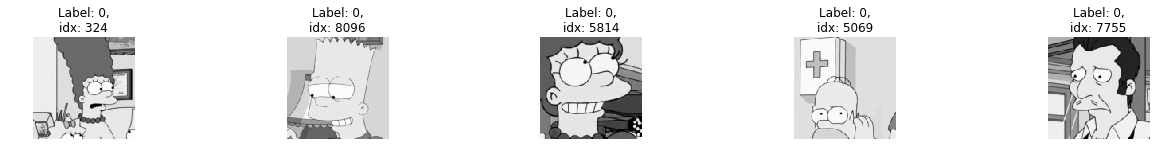

In [5]:
# in order to display images with this function, comment out the normalize() in the data loader transforms
import random
def plot_gallery(imgs,image_size,num=5,class_idx=False):
    plt.figure(figsize=(20,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_[1].reshape(img_.shape[2],img_.shape[1]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,image_size,class_idx=False)

### Discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

In [6]:
def generate_fake_sample(size):
    X = torch.rand(size, 3, image_size ,image_size).to(device, dtype=torch.float)
    return X

In [7]:
def binary_accuracy(output, target, reverse=False):
    """Computes the accuracy for multiple binary predictions"""
    pred = torch.reshape(output >= 0.5,(1,len(output)))
    truth = torch.reshape(target < 0.5,(1,len(target)))
    acc = ((pred == truth).sum()).item() / len(target)* 100
    return acc 

In [8]:
# we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
            
        )
        self.fc = nn.Sequential(
            nn.Linear(low_dim_rep*low_dim_rep*1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, low_dim_rep*low_dim_rep*1024)
        x = self.fc(x)
        return x

In [9]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True

In [10]:
discriminator(torch.zeros((batch_size,3,128,128)).to(device)).shape

torch.Size([32, 1])

In [11]:
criterion = lambda output, target: F.binary_cross_entropy(input=output,target=target)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=init_lr, betas = (0.5,0.999))

### Generator

In [12]:
def generate_latent_vector(size):
    z = torch.randn(size, latent_dim).to(device)
    return z

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, low_dim_rep*low_dim_rep*1024), # 100 is the length of our latent vector. 100 is kind of a best practice number.
            nn.LeakyReLU(0.2)
        )
        
        # The Conv2DTranspose layer can be configured with a stride of (2×2) 
        # that will quadruple the area of the input feature maps (double their width and height dimensions). 
        # It is also good practice to use a kernel size that is a factor of the stride
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1, output_padding=0), # output = > 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=0), # output = > 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=0), # output = > 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1), # output = >  128x128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(64, 3, 5, stride=1, padding=1), # bigger conv layer for smoothness
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 1024, low_dim_rep, low_dim_rep)
        x = self.cnn(x)
        return x

In [14]:
torch.cuda.empty_cache()
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [15]:
generator(generate_latent_vector(batch_size)).shape 

torch.Size([32, 3, 128, 128])

In [16]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=init_lr, betas = (0.5,0.999))

### Train

In [17]:
gen_loss=[]
dis_loss=[]
best_loss = np.inf
tolarance = 200

Epoch : 0 



C:\Users\BasuUser\Anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  """Entry point for launching an IPython kernel.


batch: 0 - loss_d: 2.2563 - loss_g: 0.0020 - loss_real: 1.8475 - loss_fake: 0.4088
batch: 25 - loss_d: 2.5576 - loss_g: 27.6310 - loss_real: 1.7726 - loss_fake: 0.7850
batch: 50 - loss_d: 3.3519 - loss_g: 27.6310 - loss_real: 0.8862 - loss_fake: 2.4657
batch: 75 - loss_d: 3.0176 - loss_g: 27.6310 - loss_real: 0.7725 - loss_fake: 2.2452
batch: 100 - loss_d: 1.2093 - loss_g: 27.6310 - loss_real: 0.4819 - loss_fake: 0.7274
batch: 125 - loss_d: 1.6575 - loss_g: 27.6310 - loss_real: 0.6417 - loss_fake: 1.0158
batch: 150 - loss_d: 3.0790 - loss_g: 27.6310 - loss_real: 0.5664 - loss_fake: 2.5126
batch: 175 - loss_d: 4.2766 - loss_g: 27.6310 - loss_real: 0.5994 - loss_fake: 3.6772
batch: 200 - loss_d: 2.9215 - loss_g: 27.6310 - loss_real: 0.5397 - loss_fake: 2.3818
batch: 225 - loss_d: 3.2810 - loss_g: 10.7679 - loss_real: 1.9310 - loss_fake: 1.3500
batch: 250 - loss_d: 1.9869 - loss_g: 2.2601 - loss_real: 0.9965 - loss_fake: 0.9904
batch: 275 - loss_d: 1.2146 - loss_g: 2.6206 - loss_real: 0.8

C:\Users\BasuUser\Anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])) is deprecated. Please ensure they have the same size.
  """Entry point for launching an IPython kernel.



D_loss: 1.1097615957260132; G_loss: 1.7125760316848755
Lowest G loss: 1.7125760316848755


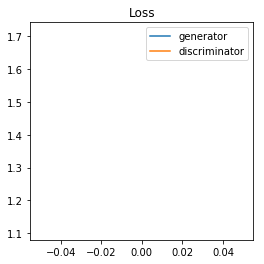


Took:  206.90391635894775  seconds
Epoch : 1 

batch: 0 - loss_d: 1.1224 - loss_g: 2.6167 - loss_real: 0.6456 - loss_fake: 0.4768
batch: 25 - loss_d: 1.1015 - loss_g: 2.4626 - loss_real: 0.6523 - loss_fake: 0.4491
batch: 50 - loss_d: 1.5082 - loss_g: 0.9298 - loss_real: 1.1880 - loss_fake: 0.3202
batch: 75 - loss_d: 1.1527 - loss_g: 1.5039 - loss_real: 0.8453 - loss_fake: 0.3074
batch: 100 - loss_d: 1.3245 - loss_g: 2.1525 - loss_real: 0.6129 - loss_fake: 0.7116
batch: 125 - loss_d: 1.8069 - loss_g: 2.1573 - loss_real: 0.9193 - loss_fake: 0.8876
batch: 150 - loss_d: 1.0492 - loss_g: 2.3108 - loss_real: 0.6013 - loss_fake: 0.4478
batch: 175 - loss_d: 1.2131 - loss_g: 1.5594 - loss_real: 0.9575 - loss_fake: 0.2557
batch: 200 - loss_d: 1.0238 - loss_g: 1.4010 - loss_real: 0.6798 - loss_fake: 0.3440
batch: 225 - loss_d: 1.0239 - loss_g: 2.2187 - loss_real: 0.5283 - loss_fake: 0.4955
batch: 250 - loss_d: 1.8127 - loss_g: 0.9065 - loss_real: 1.3422 - loss_fake: 0.4706
batch: 275 - loss_d: 1

batch: 50 - loss_d: 1.2433 - loss_g: 2.9333 - loss_real: 0.5894 - loss_fake: 0.6539
batch: 75 - loss_d: 0.9926 - loss_g: 1.8903 - loss_real: 0.5163 - loss_fake: 0.4763
batch: 100 - loss_d: 1.0689 - loss_g: 1.7436 - loss_real: 0.5910 - loss_fake: 0.4779
batch: 125 - loss_d: 1.0984 - loss_g: 2.9633 - loss_real: 0.6294 - loss_fake: 0.4690
batch: 150 - loss_d: 0.8889 - loss_g: 3.1764 - loss_real: 0.5909 - loss_fake: 0.2981
batch: 175 - loss_d: 1.2297 - loss_g: 2.2243 - loss_real: 0.5557 - loss_fake: 0.6740
batch: 200 - loss_d: 1.0406 - loss_g: 2.3963 - loss_real: 0.6112 - loss_fake: 0.4294
batch: 225 - loss_d: 0.9235 - loss_g: 2.6684 - loss_real: 0.5268 - loss_fake: 0.3968
batch: 250 - loss_d: 1.1050 - loss_g: 1.2310 - loss_real: 0.6318 - loss_fake: 0.4732
batch: 275 - loss_d: 1.0363 - loss_g: 3.2636 - loss_real: 0.5633 - loss_fake: 0.4731
batch: 300 - loss_d: 1.0098 - loss_g: 2.0594 - loss_real: 0.6007 - loss_fake: 0.4091

D_loss: 1.3539518117904663; G_loss: 2.1899285316467285
Lowest G lo

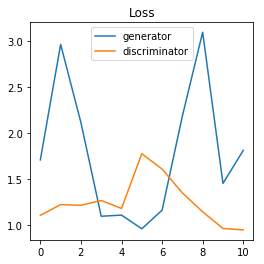


Took:  207.97499442100525  seconds
Epoch : 11 

batch: 0 - loss_d: 1.0681 - loss_g: 1.7539 - loss_real: 0.6526 - loss_fake: 0.4155
batch: 25 - loss_d: 1.2333 - loss_g: 3.4423 - loss_real: 0.5164 - loss_fake: 0.7169
batch: 50 - loss_d: 0.9851 - loss_g: 1.4827 - loss_real: 0.5797 - loss_fake: 0.4054
batch: 75 - loss_d: 0.9769 - loss_g: 2.7273 - loss_real: 0.4764 - loss_fake: 0.5004
batch: 100 - loss_d: 1.1663 - loss_g: 1.6048 - loss_real: 0.5459 - loss_fake: 0.6203
batch: 125 - loss_d: 1.2369 - loss_g: 2.7719 - loss_real: 0.6991 - loss_fake: 0.5378
batch: 150 - loss_d: 1.4247 - loss_g: 1.4170 - loss_real: 1.0409 - loss_fake: 0.3837
batch: 175 - loss_d: 1.0128 - loss_g: 1.0382 - loss_real: 0.6983 - loss_fake: 0.3144
batch: 200 - loss_d: 0.9360 - loss_g: 1.9203 - loss_real: 0.5813 - loss_fake: 0.3547
batch: 225 - loss_d: 1.4131 - loss_g: 1.2495 - loss_real: 1.1245 - loss_fake: 0.2886
batch: 250 - loss_d: 0.7876 - loss_g: 1.8519 - loss_real: 0.5929 - loss_fake: 0.1946
batch: 275 - loss_d: 

batch: 50 - loss_d: 1.0635 - loss_g: 4.0211 - loss_real: 0.5929 - loss_fake: 0.4706
batch: 75 - loss_d: 1.1240 - loss_g: 2.5069 - loss_real: 0.4788 - loss_fake: 0.6453
batch: 100 - loss_d: 1.6338 - loss_g: 5.4250 - loss_real: 0.6942 - loss_fake: 0.9396
batch: 125 - loss_d: 0.9084 - loss_g: 2.2166 - loss_real: 0.6073 - loss_fake: 0.3011
batch: 150 - loss_d: 1.4886 - loss_g: 3.9074 - loss_real: 0.6665 - loss_fake: 0.8221
batch: 175 - loss_d: 0.8651 - loss_g: 2.7075 - loss_real: 0.5724 - loss_fake: 0.2928
batch: 200 - loss_d: 0.9435 - loss_g: 2.7424 - loss_real: 0.6819 - loss_fake: 0.2615
batch: 225 - loss_d: 1.0276 - loss_g: 3.0982 - loss_real: 0.5204 - loss_fake: 0.5072
batch: 250 - loss_d: 1.2161 - loss_g: 1.7570 - loss_real: 0.8397 - loss_fake: 0.3765
batch: 275 - loss_d: 0.9664 - loss_g: 2.0546 - loss_real: 0.5911 - loss_fake: 0.3752
batch: 300 - loss_d: 1.3473 - loss_g: 2.6614 - loss_real: 0.9291 - loss_fake: 0.4182

D_loss: 0.7115662693977356; G_loss: 1.8012049198150635
Lowest G lo

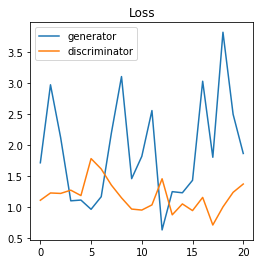


Took:  207.88657760620117  seconds
Epoch : 21 

batch: 0 - loss_d: 0.9168 - loss_g: 2.4773 - loss_real: 0.5059 - loss_fake: 0.4109
batch: 25 - loss_d: 0.8870 - loss_g: 2.7613 - loss_real: 0.4861 - loss_fake: 0.4009
batch: 50 - loss_d: 0.8643 - loss_g: 2.0772 - loss_real: 0.6238 - loss_fake: 0.2406
batch: 75 - loss_d: 0.9026 - loss_g: 3.0441 - loss_real: 0.6122 - loss_fake: 0.2904
batch: 100 - loss_d: 0.9799 - loss_g: 2.2545 - loss_real: 0.5971 - loss_fake: 0.3828
batch: 125 - loss_d: 1.5145 - loss_g: 3.2186 - loss_real: 0.4984 - loss_fake: 1.0161
batch: 150 - loss_d: 1.0233 - loss_g: 2.3153 - loss_real: 0.5568 - loss_fake: 0.4665
batch: 175 - loss_d: 1.2137 - loss_g: 1.4138 - loss_real: 0.8025 - loss_fake: 0.4112
batch: 200 - loss_d: 1.0033 - loss_g: 2.2592 - loss_real: 0.5534 - loss_fake: 0.4499
batch: 225 - loss_d: 1.7394 - loss_g: 0.9785 - loss_real: 1.3335 - loss_fake: 0.4058
batch: 250 - loss_d: 0.8597 - loss_g: 1.6265 - loss_real: 0.4809 - loss_fake: 0.3788
batch: 275 - loss_d: 

batch: 50 - loss_d: 1.1744 - loss_g: 3.1988 - loss_real: 0.5659 - loss_fake: 0.6085
batch: 75 - loss_d: 2.0439 - loss_g: 0.9110 - loss_real: 1.5631 - loss_fake: 0.4809
batch: 100 - loss_d: 0.9106 - loss_g: 2.0247 - loss_real: 0.5411 - loss_fake: 0.3695
batch: 125 - loss_d: 1.6218 - loss_g: 2.6992 - loss_real: 0.8068 - loss_fake: 0.8150
batch: 150 - loss_d: 0.7600 - loss_g: 2.8402 - loss_real: 0.4438 - loss_fake: 0.3163
batch: 175 - loss_d: 0.7757 - loss_g: 2.7675 - loss_real: 0.5639 - loss_fake: 0.2118
batch: 200 - loss_d: 0.8989 - loss_g: 4.2201 - loss_real: 0.6114 - loss_fake: 0.2875
batch: 225 - loss_d: 0.7410 - loss_g: 2.3601 - loss_real: 0.5175 - loss_fake: 0.2235
batch: 250 - loss_d: 0.8883 - loss_g: 2.4801 - loss_real: 0.5617 - loss_fake: 0.3266
batch: 275 - loss_d: 0.9623 - loss_g: 1.5722 - loss_real: 0.5471 - loss_fake: 0.4151
batch: 300 - loss_d: 0.9317 - loss_g: 2.4403 - loss_real: 0.5030 - loss_fake: 0.4287

D_loss: 0.7398844957351685; G_loss: 3.251021146774292
Lowest G los

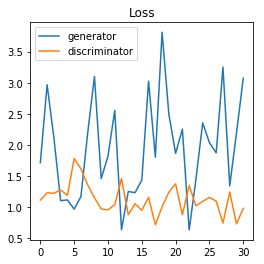


Took:  207.87360453605652  seconds
Epoch : 31 

batch: 0 - loss_d: 1.0790 - loss_g: 2.2232 - loss_real: 0.6434 - loss_fake: 0.4356
batch: 25 - loss_d: 0.9079 - loss_g: 2.5070 - loss_real: 0.5786 - loss_fake: 0.3292
batch: 50 - loss_d: 0.9572 - loss_g: 2.8417 - loss_real: 0.6880 - loss_fake: 0.2691
batch: 75 - loss_d: 1.1126 - loss_g: 3.7892 - loss_real: 0.5501 - loss_fake: 0.5625
batch: 100 - loss_d: 0.8932 - loss_g: 2.3253 - loss_real: 0.6009 - loss_fake: 0.2922
batch: 125 - loss_d: 1.2491 - loss_g: 3.4443 - loss_real: 0.6646 - loss_fake: 0.5845
batch: 150 - loss_d: 0.8830 - loss_g: 1.9111 - loss_real: 0.5843 - loss_fake: 0.2987
batch: 175 - loss_d: 0.8920 - loss_g: 2.6126 - loss_real: 0.5177 - loss_fake: 0.3743
batch: 200 - loss_d: 0.7764 - loss_g: 4.0070 - loss_real: 0.5230 - loss_fake: 0.2534
batch: 225 - loss_d: 0.8258 - loss_g: 2.4019 - loss_real: 0.5035 - loss_fake: 0.3224
batch: 250 - loss_d: 0.8575 - loss_g: 2.5319 - loss_real: 0.5682 - loss_fake: 0.2893
batch: 275 - loss_d: 

batch: 50 - loss_d: 1.3482 - loss_g: 4.3300 - loss_real: 0.6519 - loss_fake: 0.6963
batch: 75 - loss_d: 0.7953 - loss_g: 1.9082 - loss_real: 0.4818 - loss_fake: 0.3135
batch: 100 - loss_d: 0.8275 - loss_g: 2.8408 - loss_real: 0.5192 - loss_fake: 0.3084
batch: 125 - loss_d: 1.0189 - loss_g: 3.6668 - loss_real: 0.6067 - loss_fake: 0.4123
batch: 150 - loss_d: 0.6639 - loss_g: 3.5991 - loss_real: 0.5422 - loss_fake: 0.1217
batch: 175 - loss_d: 0.8461 - loss_g: 3.0111 - loss_real: 0.5111 - loss_fake: 0.3349
batch: 200 - loss_d: 0.7212 - loss_g: 2.1195 - loss_real: 0.5214 - loss_fake: 0.1998
batch: 225 - loss_d: 0.8409 - loss_g: 1.5099 - loss_real: 0.6300 - loss_fake: 0.2109
batch: 250 - loss_d: 1.0101 - loss_g: 2.8394 - loss_real: 0.6784 - loss_fake: 0.3317
batch: 275 - loss_d: 0.9363 - loss_g: 2.2579 - loss_real: 0.5313 - loss_fake: 0.4050
batch: 300 - loss_d: 0.7608 - loss_g: 2.1538 - loss_real: 0.4854 - loss_fake: 0.2754

D_loss: 0.9559369087219238; G_loss: 1.4684492349624634
Lowest G lo

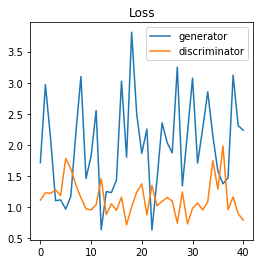


Took:  207.94561100006104  seconds
Epoch : 41 

batch: 0 - loss_d: 0.8676 - loss_g: 2.9237 - loss_real: 0.5833 - loss_fake: 0.2842
batch: 25 - loss_d: 0.9093 - loss_g: 2.1447 - loss_real: 0.8643 - loss_fake: 0.0450
batch: 50 - loss_d: 0.8522 - loss_g: 3.0419 - loss_real: 0.5368 - loss_fake: 0.3154
batch: 75 - loss_d: 0.8540 - loss_g: 2.5470 - loss_real: 0.5713 - loss_fake: 0.2828
batch: 100 - loss_d: 0.7083 - loss_g: 2.1424 - loss_real: 0.5140 - loss_fake: 0.1943
batch: 125 - loss_d: 0.9929 - loss_g: 2.9276 - loss_real: 0.5800 - loss_fake: 0.4129
batch: 150 - loss_d: 1.0205 - loss_g: 1.5430 - loss_real: 0.7058 - loss_fake: 0.3147
batch: 175 - loss_d: 0.8499 - loss_g: 1.8555 - loss_real: 0.5818 - loss_fake: 0.2681
batch: 200 - loss_d: 0.7748 - loss_g: 2.4089 - loss_real: 0.5331 - loss_fake: 0.2417
batch: 225 - loss_d: 0.9324 - loss_g: 3.8301 - loss_real: 0.5212 - loss_fake: 0.4112
batch: 250 - loss_d: 0.9005 - loss_g: 2.4452 - loss_real: 0.5865 - loss_fake: 0.3140
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.6895 - loss_g: 3.7490 - loss_real: 0.4775 - loss_fake: 0.2119
batch: 75 - loss_d: 0.8805 - loss_g: 2.2201 - loss_real: 0.5014 - loss_fake: 0.3792
batch: 100 - loss_d: 0.8172 - loss_g: 1.8292 - loss_real: 0.5842 - loss_fake: 0.2330
batch: 125 - loss_d: 0.8180 - loss_g: 2.1431 - loss_real: 0.5629 - loss_fake: 0.2551
batch: 150 - loss_d: 0.9571 - loss_g: 4.2955 - loss_real: 0.6142 - loss_fake: 0.3429
batch: 175 - loss_d: 0.9274 - loss_g: 2.5764 - loss_real: 0.5736 - loss_fake: 0.3538
batch: 200 - loss_d: 0.9927 - loss_g: 2.6398 - loss_real: 0.6275 - loss_fake: 0.3652
batch: 225 - loss_d: 0.8875 - loss_g: 2.6441 - loss_real: 0.6212 - loss_fake: 0.2662
batch: 250 - loss_d: 0.8135 - loss_g: 2.0919 - loss_real: 0.5845 - loss_fake: 0.2289
batch: 275 - loss_d: 0.9311 - loss_g: 2.2422 - loss_real: 0.4423 - loss_fake: 0.4888
batch: 300 - loss_d: 0.8544 - loss_g: 2.0525 - loss_real: 0.5781 - loss_fake: 0.2763

D_loss: 1.0218299627304077; G_loss: 4.078798770904541
Lowest G los

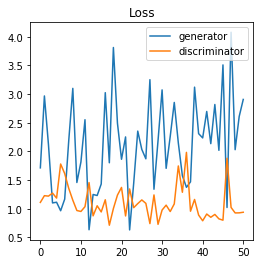


Took:  208.20941638946533  seconds
Epoch : 51 

batch: 0 - loss_d: 0.8334 - loss_g: 2.3657 - loss_real: 0.5583 - loss_fake: 0.2751
batch: 25 - loss_d: 0.8450 - loss_g: 2.6909 - loss_real: 0.5398 - loss_fake: 0.3052
batch: 50 - loss_d: 0.6925 - loss_g: 2.2146 - loss_real: 0.4796 - loss_fake: 0.2128
batch: 75 - loss_d: 0.9700 - loss_g: 2.9568 - loss_real: 0.5513 - loss_fake: 0.4187
batch: 100 - loss_d: 0.8443 - loss_g: 2.2880 - loss_real: 0.5298 - loss_fake: 0.3146
batch: 125 - loss_d: 0.8211 - loss_g: 1.7508 - loss_real: 0.5784 - loss_fake: 0.2427
batch: 150 - loss_d: 0.8799 - loss_g: 2.4861 - loss_real: 0.4968 - loss_fake: 0.3831
batch: 175 - loss_d: 0.7719 - loss_g: 2.6840 - loss_real: 0.5370 - loss_fake: 0.2349
batch: 200 - loss_d: 0.8927 - loss_g: 2.3445 - loss_real: 0.6510 - loss_fake: 0.2417
batch: 225 - loss_d: 0.9454 - loss_g: 2.8930 - loss_real: 0.6181 - loss_fake: 0.3273
batch: 250 - loss_d: 1.0164 - loss_g: 3.0559 - loss_real: 0.5357 - loss_fake: 0.4807
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.9585 - loss_g: 1.9494 - loss_real: 0.6752 - loss_fake: 0.2833
batch: 75 - loss_d: 0.9874 - loss_g: 2.8684 - loss_real: 0.5676 - loss_fake: 0.4198
batch: 100 - loss_d: 0.8926 - loss_g: 2.6791 - loss_real: 0.6011 - loss_fake: 0.2916
batch: 125 - loss_d: 0.7927 - loss_g: 3.0515 - loss_real: 0.4912 - loss_fake: 0.3015
batch: 150 - loss_d: 0.9341 - loss_g: 3.0521 - loss_real: 0.5744 - loss_fake: 0.3597
batch: 175 - loss_d: 0.7769 - loss_g: 2.0435 - loss_real: 0.5578 - loss_fake: 0.2191
batch: 200 - loss_d: 0.9365 - loss_g: 1.6640 - loss_real: 0.6230 - loss_fake: 0.3135
batch: 225 - loss_d: 0.7584 - loss_g: 2.8474 - loss_real: 0.5228 - loss_fake: 0.2356
batch: 250 - loss_d: 0.8472 - loss_g: 2.3190 - loss_real: 0.5617 - loss_fake: 0.2855
batch: 275 - loss_d: 0.9278 - loss_g: 2.6658 - loss_real: 0.5259 - loss_fake: 0.4019
batch: 300 - loss_d: 0.9640 - loss_g: 2.2317 - loss_real: 0.5702 - loss_fake: 0.3938

D_loss: 0.8422465920448303; G_loss: 3.322591781616211
Lowest G los

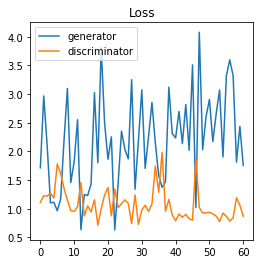


Took:  208.1613314151764  seconds
Epoch : 61 

batch: 0 - loss_d: 0.9859 - loss_g: 2.7388 - loss_real: 0.5361 - loss_fake: 0.4498
batch: 25 - loss_d: 0.8938 - loss_g: 2.7563 - loss_real: 0.5962 - loss_fake: 0.2976
batch: 50 - loss_d: 0.7945 - loss_g: 2.1705 - loss_real: 0.5130 - loss_fake: 0.2815
batch: 75 - loss_d: 0.7812 - loss_g: 2.7394 - loss_real: 0.5739 - loss_fake: 0.2073
batch: 100 - loss_d: 0.7986 - loss_g: 2.5474 - loss_real: 0.4942 - loss_fake: 0.3043
batch: 125 - loss_d: 0.8473 - loss_g: 2.7249 - loss_real: 0.4871 - loss_fake: 0.3602
batch: 150 - loss_d: 0.6844 - loss_g: 2.6474 - loss_real: 0.4983 - loss_fake: 0.1861
batch: 175 - loss_d: 0.8395 - loss_g: 3.1026 - loss_real: 0.5239 - loss_fake: 0.3156
batch: 200 - loss_d: 0.7393 - loss_g: 3.0505 - loss_real: 0.5464 - loss_fake: 0.1929
batch: 225 - loss_d: 0.8200 - loss_g: 2.6587 - loss_real: 0.5005 - loss_fake: 0.3196
batch: 250 - loss_d: 0.9192 - loss_g: 1.6107 - loss_real: 0.6549 - loss_fake: 0.2643
batch: 275 - loss_d: 0

batch: 50 - loss_d: 0.7567 - loss_g: 3.2581 - loss_real: 0.5096 - loss_fake: 0.2472
batch: 75 - loss_d: 0.8495 - loss_g: 2.6925 - loss_real: 0.5684 - loss_fake: 0.2812
batch: 100 - loss_d: 0.8855 - loss_g: 2.4711 - loss_real: 0.4765 - loss_fake: 0.4090
batch: 125 - loss_d: 0.7520 - loss_g: 2.9772 - loss_real: 0.5343 - loss_fake: 0.2177
batch: 150 - loss_d: 0.8524 - loss_g: 1.3379 - loss_real: 0.4776 - loss_fake: 0.3748
batch: 175 - loss_d: 0.7987 - loss_g: 1.9567 - loss_real: 0.5300 - loss_fake: 0.2687
batch: 200 - loss_d: 0.9235 - loss_g: 1.6552 - loss_real: 0.5167 - loss_fake: 0.4069
batch: 225 - loss_d: 0.8689 - loss_g: 3.1420 - loss_real: 0.5434 - loss_fake: 0.3255
batch: 250 - loss_d: 0.8118 - loss_g: 2.5931 - loss_real: 0.5140 - loss_fake: 0.2977
batch: 275 - loss_d: 0.6073 - loss_g: 3.8298 - loss_real: 0.4967 - loss_fake: 0.1107
batch: 300 - loss_d: 0.8164 - loss_g: 2.9683 - loss_real: 0.5779 - loss_fake: 0.2385

D_loss: 0.9150019884109497; G_loss: 2.3783812522888184
Lowest G lo

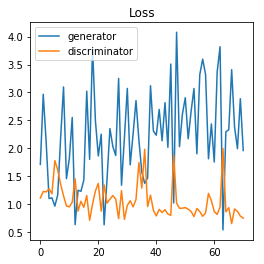


Took:  208.24196791648865  seconds
Epoch : 71 

batch: 0 - loss_d: 0.8618 - loss_g: 3.0157 - loss_real: 0.4898 - loss_fake: 0.3720
batch: 25 - loss_d: 0.8130 - loss_g: 2.4113 - loss_real: 0.4981 - loss_fake: 0.3149
batch: 50 - loss_d: 0.7763 - loss_g: 3.1674 - loss_real: 0.5159 - loss_fake: 0.2604
batch: 75 - loss_d: 0.9949 - loss_g: 2.2903 - loss_real: 0.5228 - loss_fake: 0.4721
batch: 100 - loss_d: 0.6924 - loss_g: 2.3334 - loss_real: 0.5527 - loss_fake: 0.1397
batch: 125 - loss_d: 0.9904 - loss_g: 1.8765 - loss_real: 0.7628 - loss_fake: 0.2276
batch: 150 - loss_d: 0.7598 - loss_g: 2.1238 - loss_real: 0.5271 - loss_fake: 0.2326
batch: 175 - loss_d: 0.6438 - loss_g: 2.5926 - loss_real: 0.5146 - loss_fake: 0.1292
batch: 200 - loss_d: 0.7336 - loss_g: 3.5876 - loss_real: 0.5010 - loss_fake: 0.2326
batch: 225 - loss_d: 0.8690 - loss_g: 1.8714 - loss_real: 0.5811 - loss_fake: 0.2880
batch: 250 - loss_d: 0.9690 - loss_g: 2.5558 - loss_real: 0.5394 - loss_fake: 0.4296
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7553 - loss_g: 4.0450 - loss_real: 0.4751 - loss_fake: 0.2802
batch: 75 - loss_d: 0.7704 - loss_g: 3.1724 - loss_real: 0.5099 - loss_fake: 0.2605
batch: 100 - loss_d: 0.8482 - loss_g: 3.1161 - loss_real: 0.4651 - loss_fake: 0.3831
batch: 125 - loss_d: 0.7075 - loss_g: 2.4939 - loss_real: 0.4978 - loss_fake: 0.2097
batch: 150 - loss_d: 0.8003 - loss_g: 2.9816 - loss_real: 0.5720 - loss_fake: 0.2283
batch: 175 - loss_d: 0.8799 - loss_g: 2.8786 - loss_real: 0.5061 - loss_fake: 0.3738
batch: 200 - loss_d: 0.7776 - loss_g: 3.4802 - loss_real: 0.5132 - loss_fake: 0.2643
batch: 225 - loss_d: 0.9292 - loss_g: 1.6848 - loss_real: 0.4940 - loss_fake: 0.4352
batch: 250 - loss_d: 0.8500 - loss_g: 2.4870 - loss_real: 0.5736 - loss_fake: 0.2763
batch: 275 - loss_d: 0.7672 - loss_g: 3.0691 - loss_real: 0.4980 - loss_fake: 0.2691
batch: 300 - loss_d: 0.9213 - loss_g: 2.8770 - loss_real: 0.4853 - loss_fake: 0.4360

D_loss: 0.7797907590866089; G_loss: 2.5740458965301514
Lowest G lo

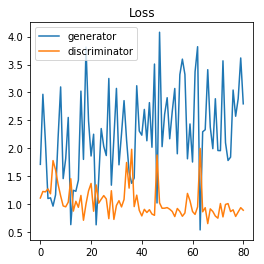


Took:  206.95871806144714  seconds
Epoch : 81 

batch: 0 - loss_d: 0.8287 - loss_g: 2.2565 - loss_real: 0.5255 - loss_fake: 0.3031
batch: 25 - loss_d: 0.7846 - loss_g: 1.8964 - loss_real: 0.5578 - loss_fake: 0.2269
batch: 50 - loss_d: 0.8391 - loss_g: 1.8085 - loss_real: 0.5104 - loss_fake: 0.3287
batch: 75 - loss_d: 0.7612 - loss_g: 2.7760 - loss_real: 0.5096 - loss_fake: 0.2516
batch: 100 - loss_d: 0.8072 - loss_g: 3.0899 - loss_real: 0.5247 - loss_fake: 0.2825
batch: 125 - loss_d: 0.7405 - loss_g: 3.2693 - loss_real: 0.4744 - loss_fake: 0.2661
batch: 150 - loss_d: 0.8253 - loss_g: 2.7392 - loss_real: 0.5399 - loss_fake: 0.2854
batch: 175 - loss_d: 0.8421 - loss_g: 2.5208 - loss_real: 0.5263 - loss_fake: 0.3159
batch: 200 - loss_d: 0.8044 - loss_g: 2.3654 - loss_real: 0.4790 - loss_fake: 0.3253
batch: 225 - loss_d: 0.7448 - loss_g: 3.5284 - loss_real: 0.5129 - loss_fake: 0.2319
batch: 250 - loss_d: 0.8598 - loss_g: 3.0108 - loss_real: 0.5554 - loss_fake: 0.3044
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7205 - loss_g: 3.7117 - loss_real: 0.5331 - loss_fake: 0.1874
batch: 75 - loss_d: 0.7922 - loss_g: 2.5170 - loss_real: 0.4929 - loss_fake: 0.2993
batch: 100 - loss_d: 0.8546 - loss_g: 2.1047 - loss_real: 0.4728 - loss_fake: 0.3818
batch: 125 - loss_d: 0.9428 - loss_g: 2.1983 - loss_real: 0.5603 - loss_fake: 0.3825
batch: 150 - loss_d: 0.7654 - loss_g: 1.9565 - loss_real: 0.4640 - loss_fake: 0.3014
batch: 175 - loss_d: 0.8848 - loss_g: 2.8920 - loss_real: 0.5328 - loss_fake: 0.3520
batch: 200 - loss_d: 1.0324 - loss_g: 2.3588 - loss_real: 0.6061 - loss_fake: 0.4264
batch: 225 - loss_d: 0.7207 - loss_g: 2.2340 - loss_real: 0.5224 - loss_fake: 0.1983
batch: 250 - loss_d: 0.6398 - loss_g: 3.5033 - loss_real: 0.4484 - loss_fake: 0.1913
batch: 275 - loss_d: 0.8060 - loss_g: 2.9575 - loss_real: 0.5047 - loss_fake: 0.3013
batch: 300 - loss_d: 0.7042 - loss_g: 3.5308 - loss_real: 0.5198 - loss_fake: 0.1844

D_loss: 0.8629284501075745; G_loss: 3.5271079540252686
Lowest G lo

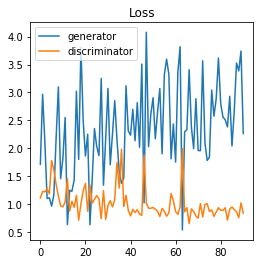


Took:  208.12072348594666  seconds
Epoch : 91 

batch: 0 - loss_d: 0.7892 - loss_g: 3.0726 - loss_real: 0.5092 - loss_fake: 0.2800
batch: 25 - loss_d: 0.7978 - loss_g: 3.0638 - loss_real: 0.4994 - loss_fake: 0.2984
batch: 50 - loss_d: 0.7169 - loss_g: 3.0713 - loss_real: 0.4904 - loss_fake: 0.2265
batch: 75 - loss_d: 0.7279 - loss_g: 2.4734 - loss_real: 0.4576 - loss_fake: 0.2703
batch: 100 - loss_d: 0.7781 - loss_g: 3.6751 - loss_real: 0.4808 - loss_fake: 0.2973
batch: 125 - loss_d: 0.7468 - loss_g: 3.1793 - loss_real: 0.5005 - loss_fake: 0.2462
batch: 150 - loss_d: 0.8030 - loss_g: 2.8207 - loss_real: 0.5395 - loss_fake: 0.2635
batch: 175 - loss_d: 0.7588 - loss_g: 1.8854 - loss_real: 0.4649 - loss_fake: 0.2939
batch: 200 - loss_d: 0.8632 - loss_g: 2.2961 - loss_real: 0.5401 - loss_fake: 0.3231
batch: 225 - loss_d: 0.8254 - loss_g: 3.5096 - loss_real: 0.5993 - loss_fake: 0.2261
batch: 250 - loss_d: 0.8751 - loss_g: 2.3035 - loss_real: 0.5259 - loss_fake: 0.3492
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.8484 - loss_g: 2.2007 - loss_real: 0.5172 - loss_fake: 0.3311
batch: 75 - loss_d: 0.6066 - loss_g: 3.6471 - loss_real: 0.5011 - loss_fake: 0.1056
batch: 100 - loss_d: 0.8278 - loss_g: 2.4412 - loss_real: 0.5404 - loss_fake: 0.2874
batch: 125 - loss_d: 0.8781 - loss_g: 2.6143 - loss_real: 0.5603 - loss_fake: 0.3178
batch: 150 - loss_d: 0.8296 - loss_g: 2.7243 - loss_real: 0.4904 - loss_fake: 0.3392
batch: 175 - loss_d: 0.8143 - loss_g: 2.8726 - loss_real: 0.5251 - loss_fake: 0.2892
batch: 200 - loss_d: 0.8029 - loss_g: 2.6643 - loss_real: 0.5238 - loss_fake: 0.2791
batch: 225 - loss_d: 0.6752 - loss_g: 2.7498 - loss_real: 0.5042 - loss_fake: 0.1709
batch: 250 - loss_d: 0.9457 - loss_g: 2.9804 - loss_real: 0.5836 - loss_fake: 0.3622
batch: 275 - loss_d: 0.7815 - loss_g: 2.7407 - loss_real: 0.4921 - loss_fake: 0.2894
batch: 300 - loss_d: 0.8025 - loss_g: 2.4283 - loss_real: 0.5487 - loss_fake: 0.2538

D_loss: 1.0267362594604492; G_loss: 3.398292064666748
Lowest G los

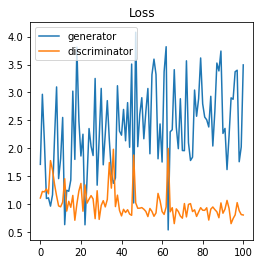


Took:  208.14080023765564  seconds
Epoch : 101 

batch: 0 - loss_d: 0.9028 - loss_g: 2.6288 - loss_real: 0.5201 - loss_fake: 0.3827
batch: 25 - loss_d: 0.8281 - loss_g: 2.2609 - loss_real: 0.4632 - loss_fake: 0.3649
batch: 50 - loss_d: 0.8152 - loss_g: 2.6043 - loss_real: 0.5671 - loss_fake: 0.2482
batch: 75 - loss_d: 0.7795 - loss_g: 2.4472 - loss_real: 0.5548 - loss_fake: 0.2248
batch: 100 - loss_d: 0.6740 - loss_g: 2.6812 - loss_real: 0.4481 - loss_fake: 0.2259
batch: 125 - loss_d: 0.6479 - loss_g: 2.6015 - loss_real: 0.4629 - loss_fake: 0.1850
batch: 150 - loss_d: 0.9475 - loss_g: 3.3438 - loss_real: 0.5567 - loss_fake: 0.3908
batch: 175 - loss_d: 0.7010 - loss_g: 3.7375 - loss_real: 0.5243 - loss_fake: 0.1767
batch: 200 - loss_d: 0.8602 - loss_g: 1.7218 - loss_real: 0.6052 - loss_fake: 0.2550
batch: 225 - loss_d: 0.7455 - loss_g: 1.9112 - loss_real: 0.4503 - loss_fake: 0.2952
batch: 250 - loss_d: 0.6562 - loss_g: 2.9064 - loss_real: 0.5081 - loss_fake: 0.1481
batch: 275 - loss_d:

batch: 50 - loss_d: 0.6418 - loss_g: 2.0981 - loss_real: 0.4407 - loss_fake: 0.2011
batch: 75 - loss_d: 0.6834 - loss_g: 2.6528 - loss_real: 0.5097 - loss_fake: 0.1737
batch: 100 - loss_d: 0.7611 - loss_g: 2.2050 - loss_real: 0.4529 - loss_fake: 0.3082
batch: 125 - loss_d: 0.8270 - loss_g: 2.1982 - loss_real: 0.4889 - loss_fake: 0.3381
batch: 150 - loss_d: 0.6595 - loss_g: 3.8344 - loss_real: 0.5541 - loss_fake: 0.1054
batch: 175 - loss_d: 0.8331 - loss_g: 3.8321 - loss_real: 0.5701 - loss_fake: 0.2630
batch: 200 - loss_d: 0.6530 - loss_g: 2.3410 - loss_real: 0.4542 - loss_fake: 0.1988
batch: 225 - loss_d: 0.6384 - loss_g: 2.7912 - loss_real: 0.4939 - loss_fake: 0.1445
batch: 250 - loss_d: 0.8370 - loss_g: 3.0019 - loss_real: 0.5456 - loss_fake: 0.2913
batch: 275 - loss_d: 0.7538 - loss_g: 2.4076 - loss_real: 0.5257 - loss_fake: 0.2281
batch: 300 - loss_d: 0.7474 - loss_g: 3.2448 - loss_real: 0.5025 - loss_fake: 0.2449

D_loss: 0.764778733253479; G_loss: 3.184133291244507
Lowest G loss

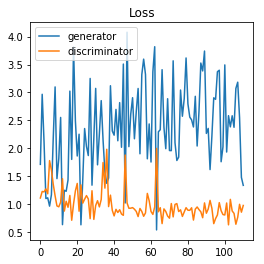


Took:  208.0785002708435  seconds
Epoch : 111 

batch: 0 - loss_d: 0.9943 - loss_g: 3.2316 - loss_real: 0.5748 - loss_fake: 0.4195
batch: 25 - loss_d: 0.7716 - loss_g: 4.1132 - loss_real: 0.5175 - loss_fake: 0.2541
batch: 50 - loss_d: 0.8698 - loss_g: 2.8857 - loss_real: 0.5153 - loss_fake: 0.3545
batch: 75 - loss_d: 0.9025 - loss_g: 1.8726 - loss_real: 0.5196 - loss_fake: 0.3829
batch: 100 - loss_d: 0.8255 - loss_g: 2.4653 - loss_real: 0.4866 - loss_fake: 0.3390
batch: 125 - loss_d: 0.7615 - loss_g: 2.5260 - loss_real: 0.5339 - loss_fake: 0.2276
batch: 150 - loss_d: 0.6921 - loss_g: 2.7694 - loss_real: 0.4594 - loss_fake: 0.2327
batch: 175 - loss_d: 0.7718 - loss_g: 2.5502 - loss_real: 0.5114 - loss_fake: 0.2603
batch: 200 - loss_d: 0.6642 - loss_g: 2.9749 - loss_real: 0.5619 - loss_fake: 0.1023
batch: 225 - loss_d: 0.9916 - loss_g: 3.1830 - loss_real: 0.5472 - loss_fake: 0.4444
batch: 250 - loss_d: 0.8494 - loss_g: 1.9848 - loss_real: 0.5157 - loss_fake: 0.3337
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.6850 - loss_g: 2.9711 - loss_real: 0.5008 - loss_fake: 0.1841
batch: 75 - loss_d: 0.7215 - loss_g: 2.6078 - loss_real: 0.5068 - loss_fake: 0.2146
batch: 100 - loss_d: 0.7931 - loss_g: 1.1675 - loss_real: 0.5281 - loss_fake: 0.2650
batch: 125 - loss_d: 0.7860 - loss_g: 2.5390 - loss_real: 0.4797 - loss_fake: 0.3063
batch: 150 - loss_d: 0.8101 - loss_g: 2.8962 - loss_real: 0.5081 - loss_fake: 0.3019
batch: 175 - loss_d: 0.7072 - loss_g: 2.7660 - loss_real: 0.4478 - loss_fake: 0.2594
batch: 200 - loss_d: 0.6718 - loss_g: 2.2867 - loss_real: 0.4767 - loss_fake: 0.1951
batch: 225 - loss_d: 0.6910 - loss_g: 3.3779 - loss_real: 0.4872 - loss_fake: 0.2039
batch: 250 - loss_d: 0.8625 - loss_g: 2.4220 - loss_real: 0.5607 - loss_fake: 0.3018
batch: 275 - loss_d: 0.7917 - loss_g: 3.3503 - loss_real: 0.5353 - loss_fake: 0.2565
batch: 300 - loss_d: 0.8602 - loss_g: 2.0699 - loss_real: 0.5040 - loss_fake: 0.3562

D_loss: 0.7824007868766785; G_loss: 2.847888469696045
Lowest G los

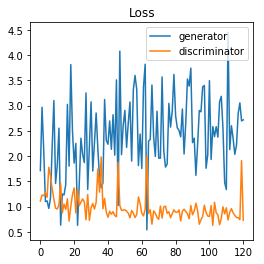


Took:  208.1800754070282  seconds
Epoch : 121 

batch: 0 - loss_d: 0.7853 - loss_g: 2.6963 - loss_real: 0.5168 - loss_fake: 0.2685
batch: 25 - loss_d: 0.7835 - loss_g: 2.4243 - loss_real: 0.4795 - loss_fake: 0.3040
batch: 50 - loss_d: 0.7747 - loss_g: 3.0983 - loss_real: 0.4961 - loss_fake: 0.2786
batch: 75 - loss_d: 0.6764 - loss_g: 3.1222 - loss_real: 0.4706 - loss_fake: 0.2058
batch: 100 - loss_d: 0.6576 - loss_g: 3.2587 - loss_real: 0.4742 - loss_fake: 0.1834
batch: 125 - loss_d: 0.8428 - loss_g: 2.7137 - loss_real: 0.4994 - loss_fake: 0.3433
batch: 150 - loss_d: 0.8547 - loss_g: 2.1748 - loss_real: 0.5726 - loss_fake: 0.2822
batch: 175 - loss_d: 0.8197 - loss_g: 2.5100 - loss_real: 0.5441 - loss_fake: 0.2756
batch: 200 - loss_d: 0.7176 - loss_g: 2.4479 - loss_real: 0.4705 - loss_fake: 0.2472
batch: 225 - loss_d: 0.7356 - loss_g: 2.6264 - loss_real: 0.5242 - loss_fake: 0.2114
batch: 250 - loss_d: 0.8464 - loss_g: 2.5482 - loss_real: 0.5022 - loss_fake: 0.3443
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7148 - loss_g: 2.4820 - loss_real: 0.4353 - loss_fake: 0.2795
batch: 75 - loss_d: 0.7434 - loss_g: 2.5943 - loss_real: 0.5270 - loss_fake: 0.2164
batch: 100 - loss_d: 0.8048 - loss_g: 3.3397 - loss_real: 0.5287 - loss_fake: 0.2761
batch: 125 - loss_d: 0.8771 - loss_g: 3.0418 - loss_real: 0.5454 - loss_fake: 0.3317
batch: 150 - loss_d: 0.7254 - loss_g: 2.9390 - loss_real: 0.5025 - loss_fake: 0.2230
batch: 175 - loss_d: 0.7407 - loss_g: 2.6635 - loss_real: 0.4620 - loss_fake: 0.2787
batch: 200 - loss_d: 0.7125 - loss_g: 3.7742 - loss_real: 0.5130 - loss_fake: 0.1995
batch: 225 - loss_d: 0.8123 - loss_g: 2.3370 - loss_real: 0.5349 - loss_fake: 0.2774
batch: 250 - loss_d: 0.5602 - loss_g: 3.4216 - loss_real: 0.4884 - loss_fake: 0.0719
batch: 275 - loss_d: 0.9933 - loss_g: 3.1403 - loss_real: 0.5644 - loss_fake: 0.4289
batch: 300 - loss_d: 0.7827 - loss_g: 3.2654 - loss_real: 0.4877 - loss_fake: 0.2949

D_loss: 0.6738781332969666; G_loss: 2.6660923957824707
Lowest G lo

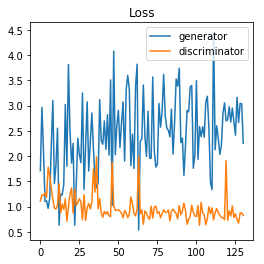


Took:  208.06625413894653  seconds
Epoch : 131 

batch: 0 - loss_d: 0.8266 - loss_g: 3.2463 - loss_real: 0.5471 - loss_fake: 0.2795
batch: 25 - loss_d: 0.7215 - loss_g: 3.4749 - loss_real: 0.5024 - loss_fake: 0.2191
batch: 50 - loss_d: 0.8780 - loss_g: 2.0678 - loss_real: 0.5036 - loss_fake: 0.3744
batch: 75 - loss_d: 0.8151 - loss_g: 2.1367 - loss_real: 0.4698 - loss_fake: 0.3454
batch: 100 - loss_d: 0.8460 - loss_g: 2.0368 - loss_real: 0.5150 - loss_fake: 0.3310
batch: 125 - loss_d: 0.7459 - loss_g: 3.0894 - loss_real: 0.4971 - loss_fake: 0.2487
batch: 150 - loss_d: 0.7617 - loss_g: 2.1120 - loss_real: 0.5343 - loss_fake: 0.2274
batch: 175 - loss_d: 1.0148 - loss_g: 2.4879 - loss_real: 0.7472 - loss_fake: 0.2675
batch: 200 - loss_d: 0.8530 - loss_g: 2.4581 - loss_real: 0.4961 - loss_fake: 0.3568
batch: 225 - loss_d: 0.8682 - loss_g: 2.4498 - loss_real: 0.5063 - loss_fake: 0.3618
batch: 250 - loss_d: 0.7144 - loss_g: 2.7115 - loss_real: 0.5389 - loss_fake: 0.1755
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8143 - loss_g: 3.2111 - loss_real: 0.5095 - loss_fake: 0.3048
batch: 75 - loss_d: 0.6940 - loss_g: 2.5551 - loss_real: 0.5215 - loss_fake: 0.1725
batch: 100 - loss_d: 0.6963 - loss_g: 2.4431 - loss_real: 0.4713 - loss_fake: 0.2249
batch: 125 - loss_d: 0.8783 - loss_g: 2.1352 - loss_real: 0.4828 - loss_fake: 0.3955
batch: 150 - loss_d: 0.7962 - loss_g: 2.0984 - loss_real: 0.4653 - loss_fake: 0.3309
batch: 175 - loss_d: 0.7320 - loss_g: 2.6371 - loss_real: 0.5312 - loss_fake: 0.2008
batch: 200 - loss_d: 0.8296 - loss_g: 1.7296 - loss_real: 0.5218 - loss_fake: 0.3078
batch: 225 - loss_d: 0.5869 - loss_g: 2.8090 - loss_real: 0.4963 - loss_fake: 0.0907
batch: 250 - loss_d: 0.8450 - loss_g: 2.6386 - loss_real: 0.5055 - loss_fake: 0.3395
batch: 275 - loss_d: 0.6240 - loss_g: 2.7160 - loss_real: 0.4930 - loss_fake: 0.1311
batch: 300 - loss_d: 0.8618 - loss_g: 2.1192 - loss_real: 0.5052 - loss_fake: 0.3566

D_loss: 0.9066290855407715; G_loss: 2.1616504192352295
Lowest G lo

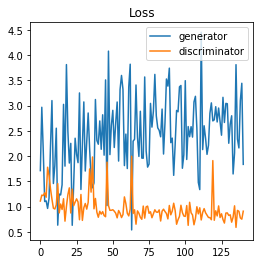


Took:  208.33700585365295  seconds
Epoch : 141 

batch: 0 - loss_d: 0.8059 - loss_g: 3.0098 - loss_real: 0.4986 - loss_fake: 0.3072
batch: 25 - loss_d: 0.7489 - loss_g: 2.5996 - loss_real: 0.4814 - loss_fake: 0.2675
batch: 50 - loss_d: 0.7136 - loss_g: 2.9634 - loss_real: 0.4655 - loss_fake: 0.2480
batch: 75 - loss_d: 0.7426 - loss_g: 3.0411 - loss_real: 0.4964 - loss_fake: 0.2462
batch: 100 - loss_d: 0.7574 - loss_g: 2.7518 - loss_real: 0.4997 - loss_fake: 0.2577
batch: 125 - loss_d: 0.7664 - loss_g: 3.0979 - loss_real: 0.5070 - loss_fake: 0.2595
batch: 150 - loss_d: 0.7714 - loss_g: 3.2674 - loss_real: 0.4932 - loss_fake: 0.2782
batch: 175 - loss_d: 0.8059 - loss_g: 2.0014 - loss_real: 0.4836 - loss_fake: 0.3223
batch: 200 - loss_d: 0.6654 - loss_g: 2.7669 - loss_real: 0.4316 - loss_fake: 0.2339
batch: 225 - loss_d: 0.7257 - loss_g: 3.5181 - loss_real: 0.5015 - loss_fake: 0.2242
batch: 250 - loss_d: 0.7326 - loss_g: 2.8308 - loss_real: 0.4327 - loss_fake: 0.3000
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8547 - loss_g: 1.9628 - loss_real: 0.4867 - loss_fake: 0.3680
batch: 75 - loss_d: 0.7340 - loss_g: 1.9406 - loss_real: 0.4250 - loss_fake: 0.3089
batch: 100 - loss_d: 0.8486 - loss_g: 2.6281 - loss_real: 0.5082 - loss_fake: 0.3404
batch: 125 - loss_d: 0.7968 - loss_g: 2.7069 - loss_real: 0.4854 - loss_fake: 0.3115
batch: 150 - loss_d: 0.7817 - loss_g: 2.7632 - loss_real: 0.4897 - loss_fake: 0.2919
batch: 175 - loss_d: 0.7307 - loss_g: 3.0214 - loss_real: 0.5063 - loss_fake: 0.2243
batch: 200 - loss_d: 0.9245 - loss_g: 2.9177 - loss_real: 0.6018 - loss_fake: 0.3227
batch: 225 - loss_d: 0.9122 - loss_g: 1.6037 - loss_real: 0.5054 - loss_fake: 0.4068
batch: 250 - loss_d: 0.6662 - loss_g: 2.4913 - loss_real: 0.5121 - loss_fake: 0.1541
batch: 275 - loss_d: 0.8381 - loss_g: 2.4064 - loss_real: 0.5238 - loss_fake: 0.3143
batch: 300 - loss_d: 0.8002 - loss_g: 2.5207 - loss_real: 0.5235 - loss_fake: 0.2767

D_loss: 0.7540359497070312; G_loss: 2.2712206840515137
Lowest G lo

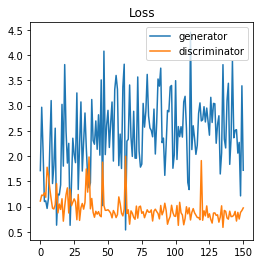


Took:  208.30584716796875  seconds
Epoch : 151 

batch: 0 - loss_d: 0.9804 - loss_g: 3.7380 - loss_real: 0.6025 - loss_fake: 0.3779
batch: 25 - loss_d: 0.8608 - loss_g: 2.8439 - loss_real: 0.4985 - loss_fake: 0.3623
batch: 50 - loss_d: 0.7758 - loss_g: 3.1342 - loss_real: 0.5233 - loss_fake: 0.2524
batch: 75 - loss_d: 0.8242 - loss_g: 2.3859 - loss_real: 0.5256 - loss_fake: 0.2986
batch: 100 - loss_d: 0.8302 - loss_g: 1.8468 - loss_real: 0.4803 - loss_fake: 0.3499
batch: 125 - loss_d: 0.9870 - loss_g: 1.9333 - loss_real: 0.5335 - loss_fake: 0.4534
batch: 150 - loss_d: 0.7763 - loss_g: 2.8699 - loss_real: 0.5375 - loss_fake: 0.2388
batch: 175 - loss_d: 0.6029 - loss_g: 3.3071 - loss_real: 0.4883 - loss_fake: 0.1146
batch: 200 - loss_d: 0.6894 - loss_g: 2.3367 - loss_real: 0.5001 - loss_fake: 0.1893
batch: 225 - loss_d: 0.7938 - loss_g: 3.3581 - loss_real: 0.5251 - loss_fake: 0.2688
batch: 250 - loss_d: 0.8713 - loss_g: 1.7093 - loss_real: 0.4872 - loss_fake: 0.3840
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8292 - loss_g: 2.5337 - loss_real: 0.5508 - loss_fake: 0.2784
batch: 75 - loss_d: 0.7246 - loss_g: 1.7226 - loss_real: 0.4994 - loss_fake: 0.2251
batch: 100 - loss_d: 0.7328 - loss_g: 3.3724 - loss_real: 0.4726 - loss_fake: 0.2603
batch: 125 - loss_d: 0.8520 - loss_g: 2.4524 - loss_real: 0.5060 - loss_fake: 0.3460
batch: 150 - loss_d: 0.8141 - loss_g: 2.2552 - loss_real: 0.4991 - loss_fake: 0.3150
batch: 175 - loss_d: 0.8165 - loss_g: 1.9781 - loss_real: 0.5284 - loss_fake: 0.2881
batch: 200 - loss_d: 0.7015 - loss_g: 2.8399 - loss_real: 0.4658 - loss_fake: 0.2357
batch: 225 - loss_d: 0.8144 - loss_g: 3.2279 - loss_real: 0.5355 - loss_fake: 0.2789
batch: 250 - loss_d: 0.7290 - loss_g: 2.2116 - loss_real: 0.4926 - loss_fake: 0.2364
batch: 275 - loss_d: 0.8445 - loss_g: 1.9647 - loss_real: 0.4702 - loss_fake: 0.3743
batch: 300 - loss_d: 0.7963 - loss_g: 2.4373 - loss_real: 0.4858 - loss_fake: 0.3105

D_loss: 0.7764678597450256; G_loss: 3.0822060108184814
Lowest G lo

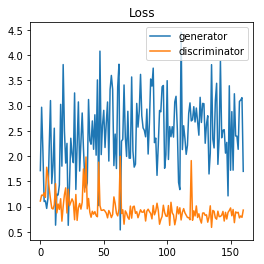


Took:  207.96274733543396  seconds
Epoch : 161 

batch: 0 - loss_d: 0.9124 - loss_g: 2.6032 - loss_real: 0.5249 - loss_fake: 0.3875
batch: 25 - loss_d: 0.8488 - loss_g: 1.5986 - loss_real: 0.5091 - loss_fake: 0.3397
batch: 50 - loss_d: 0.8595 - loss_g: 2.7215 - loss_real: 0.5276 - loss_fake: 0.3318
batch: 75 - loss_d: 0.7654 - loss_g: 3.3440 - loss_real: 0.5480 - loss_fake: 0.2174
batch: 100 - loss_d: 0.8165 - loss_g: 2.7152 - loss_real: 0.4786 - loss_fake: 0.3379
batch: 125 - loss_d: 0.7687 - loss_g: 1.8079 - loss_real: 0.4661 - loss_fake: 0.3026
batch: 150 - loss_d: 0.7229 - loss_g: 2.8720 - loss_real: 0.4880 - loss_fake: 0.2350
batch: 175 - loss_d: 0.8372 - loss_g: 2.6893 - loss_real: 0.4892 - loss_fake: 0.3479
batch: 200 - loss_d: 0.8270 - loss_g: 2.0901 - loss_real: 0.5075 - loss_fake: 0.3196
batch: 225 - loss_d: 0.8060 - loss_g: 2.5610 - loss_real: 0.4893 - loss_fake: 0.3167
batch: 250 - loss_d: 0.7892 - loss_g: 3.4341 - loss_real: 0.5124 - loss_fake: 0.2768
batch: 275 - loss_d:

batch: 50 - loss_d: 0.9217 - loss_g: 2.2868 - loss_real: 0.4555 - loss_fake: 0.4662
batch: 75 - loss_d: 0.7954 - loss_g: 2.4079 - loss_real: 0.4815 - loss_fake: 0.3140
batch: 100 - loss_d: 0.8321 - loss_g: 1.9342 - loss_real: 0.4890 - loss_fake: 0.3431
batch: 125 - loss_d: 0.7770 - loss_g: 2.3088 - loss_real: 0.4556 - loss_fake: 0.3213
batch: 150 - loss_d: 0.7943 - loss_g: 3.0441 - loss_real: 0.5099 - loss_fake: 0.2845
batch: 175 - loss_d: 0.6990 - loss_g: 2.7861 - loss_real: 0.4770 - loss_fake: 0.2220
batch: 200 - loss_d: 0.7434 - loss_g: 3.4159 - loss_real: 0.5173 - loss_fake: 0.2262
batch: 225 - loss_d: 0.8475 - loss_g: 1.6953 - loss_real: 0.5124 - loss_fake: 0.3351
batch: 250 - loss_d: 0.8595 - loss_g: 3.8156 - loss_real: 0.5646 - loss_fake: 0.2950
batch: 275 - loss_d: 0.7936 - loss_g: 2.5843 - loss_real: 0.5174 - loss_fake: 0.2762
batch: 300 - loss_d: 0.8216 - loss_g: 2.2432 - loss_real: 0.4929 - loss_fake: 0.3287

D_loss: 0.8329952955245972; G_loss: 2.109177827835083
Lowest G los

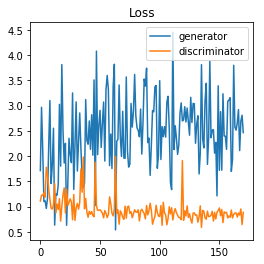


Took:  208.04428625106812  seconds
Epoch : 171 

batch: 0 - loss_d: 0.7953 - loss_g: 3.5100 - loss_real: 0.4832 - loss_fake: 0.3121
batch: 25 - loss_d: 0.6683 - loss_g: 2.6582 - loss_real: 0.4821 - loss_fake: 0.1862
batch: 50 - loss_d: 0.6020 - loss_g: 2.1249 - loss_real: 0.4732 - loss_fake: 0.1288
batch: 75 - loss_d: 0.9255 - loss_g: 2.0131 - loss_real: 0.4893 - loss_fake: 0.4362
batch: 100 - loss_d: 0.6628 - loss_g: 3.1624 - loss_real: 0.5113 - loss_fake: 0.1515
batch: 125 - loss_d: 0.8392 - loss_g: 2.3237 - loss_real: 0.5369 - loss_fake: 0.3023
batch: 150 - loss_d: 0.7876 - loss_g: 3.0599 - loss_real: 0.5047 - loss_fake: 0.2829
batch: 175 - loss_d: 0.7494 - loss_g: 2.5346 - loss_real: 0.5019 - loss_fake: 0.2475
batch: 200 - loss_d: 0.8123 - loss_g: 2.5770 - loss_real: 0.4843 - loss_fake: 0.3280
batch: 225 - loss_d: 0.6970 - loss_g: 2.4836 - loss_real: 0.4582 - loss_fake: 0.2388
batch: 250 - loss_d: 0.6914 - loss_g: 2.4938 - loss_real: 0.4847 - loss_fake: 0.2067
batch: 275 - loss_d:

batch: 50 - loss_d: 0.6864 - loss_g: 2.7103 - loss_real: 0.5198 - loss_fake: 0.1666
batch: 75 - loss_d: 0.8415 - loss_g: 3.3824 - loss_real: 0.5426 - loss_fake: 0.2989
batch: 100 - loss_d: 0.7659 - loss_g: 3.1947 - loss_real: 0.4976 - loss_fake: 0.2683
batch: 125 - loss_d: 0.6792 - loss_g: 3.3122 - loss_real: 0.5364 - loss_fake: 0.1428
batch: 150 - loss_d: 0.7441 - loss_g: 3.3945 - loss_real: 0.5113 - loss_fake: 0.2328
batch: 175 - loss_d: 0.8360 - loss_g: 2.7160 - loss_real: 0.5155 - loss_fake: 0.3206
batch: 200 - loss_d: 0.8374 - loss_g: 2.6848 - loss_real: 0.5109 - loss_fake: 0.3265
batch: 225 - loss_d: 0.7679 - loss_g: 2.7607 - loss_real: 0.5051 - loss_fake: 0.2628
batch: 250 - loss_d: 0.7487 - loss_g: 2.0243 - loss_real: 0.4718 - loss_fake: 0.2770
batch: 275 - loss_d: 0.9067 - loss_g: 2.2156 - loss_real: 0.5824 - loss_fake: 0.3243
batch: 300 - loss_d: 0.7232 - loss_g: 3.2223 - loss_real: 0.4592 - loss_fake: 0.2641

D_loss: 0.8755307197570801; G_loss: 2.8537895679473877
Lowest G lo

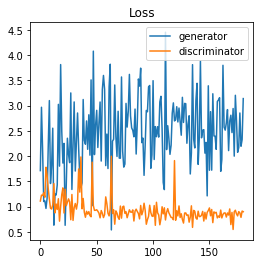


Took:  208.15324139595032  seconds
Epoch : 181 

batch: 0 - loss_d: 0.7739 - loss_g: 2.5455 - loss_real: 0.4925 - loss_fake: 0.2814
batch: 25 - loss_d: 0.6788 - loss_g: 2.8534 - loss_real: 0.5188 - loss_fake: 0.1600
batch: 50 - loss_d: 0.7035 - loss_g: 2.4740 - loss_real: 0.4746 - loss_fake: 0.2289
batch: 75 - loss_d: 0.8941 - loss_g: 2.5320 - loss_real: 0.5237 - loss_fake: 0.3704
batch: 100 - loss_d: 0.9572 - loss_g: 2.6179 - loss_real: 0.5707 - loss_fake: 0.3865
batch: 125 - loss_d: 0.6320 - loss_g: 2.7204 - loss_real: 0.4994 - loss_fake: 0.1326
batch: 150 - loss_d: 0.8167 - loss_g: 2.4623 - loss_real: 0.4858 - loss_fake: 0.3309
batch: 175 - loss_d: 0.8024 - loss_g: 2.8864 - loss_real: 0.5268 - loss_fake: 0.2756
batch: 200 - loss_d: 0.7572 - loss_g: 2.9561 - loss_real: 0.5216 - loss_fake: 0.2356
batch: 225 - loss_d: 0.6739 - loss_g: 2.9238 - loss_real: 0.4772 - loss_fake: 0.1967
batch: 250 - loss_d: 0.6673 - loss_g: 2.7196 - loss_real: 0.5004 - loss_fake: 0.1670
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8239 - loss_g: 1.6028 - loss_real: 0.4630 - loss_fake: 0.3609
batch: 75 - loss_d: 0.8164 - loss_g: 2.8279 - loss_real: 0.4969 - loss_fake: 0.3194
batch: 100 - loss_d: 0.8270 - loss_g: 2.0196 - loss_real: 0.4709 - loss_fake: 0.3561
batch: 125 - loss_d: 0.7637 - loss_g: 2.3832 - loss_real: 0.5023 - loss_fake: 0.2613
batch: 150 - loss_d: 0.8307 - loss_g: 3.0641 - loss_real: 0.5257 - loss_fake: 0.3050
batch: 175 - loss_d: 0.7004 - loss_g: 2.7222 - loss_real: 0.4792 - loss_fake: 0.2213
batch: 200 - loss_d: 0.6625 - loss_g: 2.8846 - loss_real: 0.4666 - loss_fake: 0.1959
batch: 225 - loss_d: 0.8247 - loss_g: 2.3342 - loss_real: 0.4887 - loss_fake: 0.3360
batch: 250 - loss_d: 0.6430 - loss_g: 3.0943 - loss_real: 0.4505 - loss_fake: 0.1925
batch: 275 - loss_d: 0.7753 - loss_g: 2.5469 - loss_real: 0.5028 - loss_fake: 0.2725
batch: 300 - loss_d: 0.6988 - loss_g: 3.6671 - loss_real: 0.4694 - loss_fake: 0.2294

D_loss: 0.9114446640014648; G_loss: 3.3330397605895996
Lowest G lo

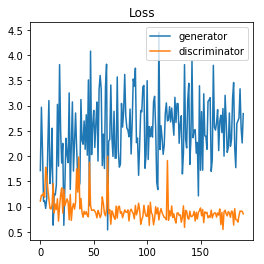


Took:  208.27216792106628  seconds
Epoch : 191 

batch: 0 - loss_d: 0.7107 - loss_g: 2.5842 - loss_real: 0.5028 - loss_fake: 0.2079
batch: 25 - loss_d: 0.9029 - loss_g: 1.9285 - loss_real: 0.4985 - loss_fake: 0.4044
batch: 50 - loss_d: 0.7335 - loss_g: 3.1714 - loss_real: 0.4651 - loss_fake: 0.2684
batch: 75 - loss_d: 0.7873 - loss_g: 2.2915 - loss_real: 0.5264 - loss_fake: 0.2609
batch: 100 - loss_d: 0.8777 - loss_g: 2.5369 - loss_real: 0.4475 - loss_fake: 0.4303
batch: 125 - loss_d: 0.7527 - loss_g: 2.5755 - loss_real: 0.5008 - loss_fake: 0.2519
batch: 150 - loss_d: 0.8602 - loss_g: 2.6119 - loss_real: 0.5399 - loss_fake: 0.3203
batch: 175 - loss_d: 0.7724 - loss_g: 2.3226 - loss_real: 0.4563 - loss_fake: 0.3160
batch: 200 - loss_d: 0.7809 - loss_g: 2.7886 - loss_real: 0.4897 - loss_fake: 0.2912
batch: 225 - loss_d: 0.8503 - loss_g: 2.7628 - loss_real: 0.5041 - loss_fake: 0.3462
batch: 250 - loss_d: 0.7921 - loss_g: 2.3100 - loss_real: 0.4488 - loss_fake: 0.3433
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8082 - loss_g: 2.4153 - loss_real: 0.5325 - loss_fake: 0.2758
batch: 75 - loss_d: 0.7273 - loss_g: 3.2431 - loss_real: 0.5168 - loss_fake: 0.2104
batch: 100 - loss_d: 0.9945 - loss_g: 1.7915 - loss_real: 0.4959 - loss_fake: 0.4987
batch: 125 - loss_d: 0.7366 - loss_g: 2.8045 - loss_real: 0.5487 - loss_fake: 0.1879
batch: 150 - loss_d: 0.7387 - loss_g: 2.5313 - loss_real: 0.4988 - loss_fake: 0.2399
batch: 175 - loss_d: 0.7988 - loss_g: 2.6850 - loss_real: 0.4818 - loss_fake: 0.3170
batch: 200 - loss_d: 0.8282 - loss_g: 2.6623 - loss_real: 0.5745 - loss_fake: 0.2536
batch: 225 - loss_d: 0.6941 - loss_g: 3.4774 - loss_real: 0.4886 - loss_fake: 0.2055
batch: 250 - loss_d: 0.7341 - loss_g: 1.7567 - loss_real: 0.4865 - loss_fake: 0.2476
batch: 275 - loss_d: 0.8513 - loss_g: 2.6050 - loss_real: 0.5050 - loss_fake: 0.3464
batch: 300 - loss_d: 0.7996 - loss_g: 3.3983 - loss_real: 0.4969 - loss_fake: 0.3027

D_loss: 0.8716882467269897; G_loss: 1.612791895866394
Lowest G los

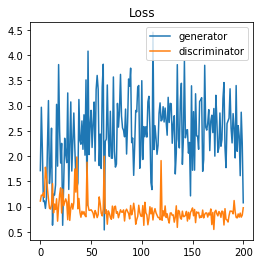


Took:  208.29520225524902  seconds
Epoch : 201 

batch: 0 - loss_d: 1.0324 - loss_g: 3.6789 - loss_real: 0.5546 - loss_fake: 0.4778
batch: 25 - loss_d: 0.7062 - loss_g: 2.8145 - loss_real: 0.4695 - loss_fake: 0.2367
batch: 50 - loss_d: 0.7484 - loss_g: 3.2011 - loss_real: 0.5364 - loss_fake: 0.2119
batch: 75 - loss_d: 0.6737 - loss_g: 2.6547 - loss_real: 0.4341 - loss_fake: 0.2396
batch: 100 - loss_d: 0.7284 - loss_g: 2.5516 - loss_real: 0.4612 - loss_fake: 0.2672
batch: 125 - loss_d: 0.7184 - loss_g: 3.5910 - loss_real: 0.5026 - loss_fake: 0.2158
batch: 150 - loss_d: 0.7499 - loss_g: 2.5500 - loss_real: 0.4792 - loss_fake: 0.2707
batch: 175 - loss_d: 0.7645 - loss_g: 2.7224 - loss_real: 0.4455 - loss_fake: 0.3190
batch: 200 - loss_d: 0.7050 - loss_g: 1.9146 - loss_real: 0.4637 - loss_fake: 0.2413
batch: 225 - loss_d: 0.7427 - loss_g: 2.4907 - loss_real: 0.5284 - loss_fake: 0.2143
batch: 250 - loss_d: 0.8029 - loss_g: 3.1690 - loss_real: 0.5305 - loss_fake: 0.2724
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8530 - loss_g: 2.5663 - loss_real: 0.4940 - loss_fake: 0.3590
batch: 75 - loss_d: 0.8719 - loss_g: 2.6197 - loss_real: 0.5360 - loss_fake: 0.3359
batch: 100 - loss_d: 0.8324 - loss_g: 2.1234 - loss_real: 0.5244 - loss_fake: 0.3080
batch: 125 - loss_d: 0.7367 - loss_g: 3.0223 - loss_real: 0.5051 - loss_fake: 0.2316
batch: 150 - loss_d: 0.7432 - loss_g: 2.3178 - loss_real: 0.5043 - loss_fake: 0.2389
batch: 175 - loss_d: 0.6875 - loss_g: 2.3867 - loss_real: 0.4489 - loss_fake: 0.2386
batch: 200 - loss_d: 0.8162 - loss_g: 2.8785 - loss_real: 0.5296 - loss_fake: 0.2867
batch: 225 - loss_d: 0.7328 - loss_g: 2.8831 - loss_real: 0.4882 - loss_fake: 0.2446
batch: 250 - loss_d: 0.9289 - loss_g: 2.1587 - loss_real: 0.4827 - loss_fake: 0.4463
batch: 275 - loss_d: 0.7218 - loss_g: 2.8152 - loss_real: 0.4997 - loss_fake: 0.2221
batch: 300 - loss_d: 0.8130 - loss_g: 1.6459 - loss_real: 0.4695 - loss_fake: 0.3435

D_loss: 0.8047019243240356; G_loss: 2.3341856002807617
Lowest G lo

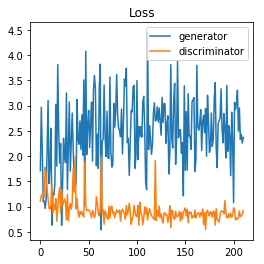


Took:  208.11963486671448  seconds
Epoch : 211 

batch: 0 - loss_d: 0.7479 - loss_g: 2.3740 - loss_real: 0.5005 - loss_fake: 0.2473
batch: 25 - loss_d: 0.8514 - loss_g: 3.1792 - loss_real: 0.5303 - loss_fake: 0.3211
batch: 50 - loss_d: 0.7215 - loss_g: 3.2813 - loss_real: 0.4954 - loss_fake: 0.2260
batch: 75 - loss_d: 0.6824 - loss_g: 2.7629 - loss_real: 0.4970 - loss_fake: 0.1854
batch: 100 - loss_d: 0.7312 - loss_g: 3.0610 - loss_real: 0.4992 - loss_fake: 0.2319
batch: 125 - loss_d: 0.7781 - loss_g: 2.1605 - loss_real: 0.4776 - loss_fake: 0.3005
batch: 150 - loss_d: 0.8934 - loss_g: 2.4187 - loss_real: 0.5329 - loss_fake: 0.3604
batch: 175 - loss_d: 0.8660 - loss_g: 2.2742 - loss_real: 0.5308 - loss_fake: 0.3352
batch: 200 - loss_d: 0.7069 - loss_g: 3.2050 - loss_real: 0.4369 - loss_fake: 0.2699
batch: 225 - loss_d: 0.8167 - loss_g: 2.4713 - loss_real: 0.5011 - loss_fake: 0.3156
batch: 250 - loss_d: 0.7796 - loss_g: 2.4286 - loss_real: 0.5072 - loss_fake: 0.2723
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8099 - loss_g: 1.9449 - loss_real: 0.4599 - loss_fake: 0.3500
batch: 75 - loss_d: 0.8273 - loss_g: 2.2002 - loss_real: 0.4876 - loss_fake: 0.3397
batch: 100 - loss_d: 0.7425 - loss_g: 2.8579 - loss_real: 0.5167 - loss_fake: 0.2258
batch: 125 - loss_d: 0.6553 - loss_g: 3.0515 - loss_real: 0.4979 - loss_fake: 0.1575
batch: 150 - loss_d: 0.6040 - loss_g: 2.6309 - loss_real: 0.4996 - loss_fake: 0.1044
batch: 175 - loss_d: 0.6616 - loss_g: 2.9968 - loss_real: 0.4495 - loss_fake: 0.2121
batch: 200 - loss_d: 0.8607 - loss_g: 2.0446 - loss_real: 0.4874 - loss_fake: 0.3733
batch: 225 - loss_d: 0.8592 - loss_g: 1.6287 - loss_real: 0.4987 - loss_fake: 0.3606
batch: 250 - loss_d: 0.7914 - loss_g: 2.6569 - loss_real: 0.4834 - loss_fake: 0.3080
batch: 275 - loss_d: 0.8508 - loss_g: 3.5234 - loss_real: 0.5230 - loss_fake: 0.3278
batch: 300 - loss_d: 0.7084 - loss_g: 1.7979 - loss_real: 0.4716 - loss_fake: 0.2367

D_loss: 0.8498289585113525; G_loss: 1.9482519626617432
Lowest G lo

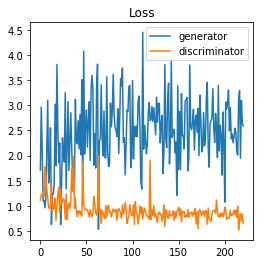


Took:  208.1746006011963  seconds
Epoch : 221 

batch: 0 - loss_d: 0.8125 - loss_g: 2.8829 - loss_real: 0.4937 - loss_fake: 0.3189
batch: 25 - loss_d: 0.6817 - loss_g: 2.8017 - loss_real: 0.4942 - loss_fake: 0.1875
batch: 50 - loss_d: 0.6877 - loss_g: 2.9590 - loss_real: 0.4731 - loss_fake: 0.2146
batch: 75 - loss_d: 0.6942 - loss_g: 2.3442 - loss_real: 0.4637 - loss_fake: 0.2305
batch: 100 - loss_d: 0.8366 - loss_g: 2.1317 - loss_real: 0.5077 - loss_fake: 0.3289
batch: 125 - loss_d: 0.8318 - loss_g: 2.8008 - loss_real: 0.5028 - loss_fake: 0.3291
batch: 150 - loss_d: 0.7484 - loss_g: 2.5626 - loss_real: 0.5011 - loss_fake: 0.2473
batch: 175 - loss_d: 0.6363 - loss_g: 3.0093 - loss_real: 0.4869 - loss_fake: 0.1494
batch: 200 - loss_d: 0.8134 - loss_g: 2.5134 - loss_real: 0.4869 - loss_fake: 0.3265
batch: 225 - loss_d: 0.7253 - loss_g: 2.5839 - loss_real: 0.4799 - loss_fake: 0.2454
batch: 250 - loss_d: 0.8712 - loss_g: 2.1372 - loss_real: 0.5124 - loss_fake: 0.3588
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7590 - loss_g: 2.6132 - loss_real: 0.4789 - loss_fake: 0.2801
batch: 75 - loss_d: 0.7453 - loss_g: 2.4007 - loss_real: 0.4821 - loss_fake: 0.2632
batch: 100 - loss_d: 0.7808 - loss_g: 2.7851 - loss_real: 0.4915 - loss_fake: 0.2892
batch: 125 - loss_d: 0.7613 - loss_g: 2.5708 - loss_real: 0.5055 - loss_fake: 0.2558
batch: 150 - loss_d: 0.7857 - loss_g: 2.4969 - loss_real: 0.4943 - loss_fake: 0.2914
batch: 175 - loss_d: 0.8171 - loss_g: 2.8522 - loss_real: 0.5461 - loss_fake: 0.2711
batch: 200 - loss_d: 0.9063 - loss_g: 2.4709 - loss_real: 0.5089 - loss_fake: 0.3974
batch: 225 - loss_d: 0.7697 - loss_g: 2.8015 - loss_real: 0.4759 - loss_fake: 0.2938
batch: 250 - loss_d: 0.7389 - loss_g: 3.0195 - loss_real: 0.4876 - loss_fake: 0.2514
batch: 275 - loss_d: 0.6518 - loss_g: 2.9699 - loss_real: 0.4728 - loss_fake: 0.1789
batch: 300 - loss_d: 0.7389 - loss_g: 2.7957 - loss_real: 0.4568 - loss_fake: 0.2820

D_loss: 0.8944741487503052; G_loss: 2.2949085235595703
Lowest G lo

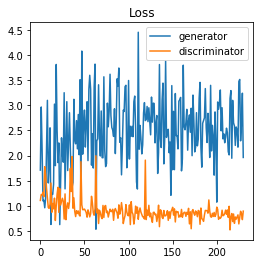


Took:  208.5029706954956  seconds
Epoch : 231 

batch: 0 - loss_d: 0.8850 - loss_g: 2.4788 - loss_real: 0.5111 - loss_fake: 0.3739
batch: 25 - loss_d: 0.8418 - loss_g: 2.7782 - loss_real: 0.4887 - loss_fake: 0.3532
batch: 50 - loss_d: 0.7478 - loss_g: 2.5751 - loss_real: 0.4937 - loss_fake: 0.2541
batch: 75 - loss_d: 0.7585 - loss_g: 3.4330 - loss_real: 0.5135 - loss_fake: 0.2451
batch: 100 - loss_d: 0.7039 - loss_g: 2.8881 - loss_real: 0.4319 - loss_fake: 0.2720
batch: 125 - loss_d: 0.8993 - loss_g: 2.2954 - loss_real: 0.4861 - loss_fake: 0.4131
batch: 150 - loss_d: 0.6678 - loss_g: 2.9030 - loss_real: 0.4586 - loss_fake: 0.2092
batch: 175 - loss_d: 0.6222 - loss_g: 2.4971 - loss_real: 0.4456 - loss_fake: 0.1766
batch: 200 - loss_d: 0.7298 - loss_g: 3.4108 - loss_real: 0.4950 - loss_fake: 0.2348
batch: 225 - loss_d: 0.7085 - loss_g: 3.6402 - loss_real: 0.5280 - loss_fake: 0.1805
batch: 250 - loss_d: 0.8580 - loss_g: 3.0227 - loss_real: 0.5296 - loss_fake: 0.3284
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7607 - loss_g: 3.1066 - loss_real: 0.5268 - loss_fake: 0.2339
batch: 75 - loss_d: 0.7432 - loss_g: 2.5211 - loss_real: 0.5011 - loss_fake: 0.2422
batch: 100 - loss_d: 0.8059 - loss_g: 3.4509 - loss_real: 0.4953 - loss_fake: 0.3106
batch: 125 - loss_d: 0.7148 - loss_g: 2.9493 - loss_real: 0.4777 - loss_fake: 0.2370
batch: 150 - loss_d: 0.7373 - loss_g: 2.6665 - loss_real: 0.4462 - loss_fake: 0.2911
batch: 175 - loss_d: 0.8756 - loss_g: 2.3302 - loss_real: 0.5323 - loss_fake: 0.3433
batch: 200 - loss_d: 0.8281 - loss_g: 2.3325 - loss_real: 0.4747 - loss_fake: 0.3534
batch: 225 - loss_d: 0.8465 - loss_g: 2.3987 - loss_real: 0.5196 - loss_fake: 0.3268
batch: 250 - loss_d: 0.8869 - loss_g: 1.4002 - loss_real: 0.5793 - loss_fake: 0.3076
batch: 275 - loss_d: 0.7496 - loss_g: 2.6245 - loss_real: 0.4365 - loss_fake: 0.3132
batch: 300 - loss_d: 0.8177 - loss_g: 2.9072 - loss_real: 0.5380 - loss_fake: 0.2797

D_loss: 0.9761226177215576; G_loss: 2.682640314102173
Lowest G los

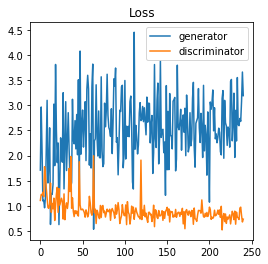


Took:  208.02918124198914  seconds
Epoch : 241 

batch: 0 - loss_d: 0.7922 - loss_g: 3.3627 - loss_real: 0.5237 - loss_fake: 0.2685
batch: 25 - loss_d: 0.7785 - loss_g: 2.6189 - loss_real: 0.5113 - loss_fake: 0.2672
batch: 50 - loss_d: 0.8501 - loss_g: 1.8800 - loss_real: 0.4962 - loss_fake: 0.3538
batch: 75 - loss_d: 0.7137 - loss_g: 3.1378 - loss_real: 0.5392 - loss_fake: 0.1745
batch: 100 - loss_d: 0.7774 - loss_g: 2.2173 - loss_real: 0.4834 - loss_fake: 0.2940
batch: 125 - loss_d: 0.8270 - loss_g: 2.0282 - loss_real: 0.4968 - loss_fake: 0.3302
batch: 150 - loss_d: 0.7489 - loss_g: 1.9564 - loss_real: 0.4952 - loss_fake: 0.2537
batch: 175 - loss_d: 0.8387 - loss_g: 2.4067 - loss_real: 0.5212 - loss_fake: 0.3175
batch: 200 - loss_d: 0.6298 - loss_g: 2.7985 - loss_real: 0.4662 - loss_fake: 0.1636
batch: 225 - loss_d: 0.6835 - loss_g: 2.7731 - loss_real: 0.4849 - loss_fake: 0.1986
batch: 250 - loss_d: 0.7845 - loss_g: 1.4953 - loss_real: 0.3877 - loss_fake: 0.3968
batch: 275 - loss_d:

batch: 50 - loss_d: 0.6784 - loss_g: 3.3480 - loss_real: 0.4968 - loss_fake: 0.1817
batch: 75 - loss_d: 0.7041 - loss_g: 3.0495 - loss_real: 0.5023 - loss_fake: 0.2018
batch: 100 - loss_d: 0.5922 - loss_g: 3.3180 - loss_real: 0.4991 - loss_fake: 0.0931
batch: 125 - loss_d: 0.9055 - loss_g: 2.4342 - loss_real: 0.4541 - loss_fake: 0.4514
batch: 150 - loss_d: 0.6704 - loss_g: 2.5164 - loss_real: 0.4774 - loss_fake: 0.1929
batch: 175 - loss_d: 0.7080 - loss_g: 3.0795 - loss_real: 0.5064 - loss_fake: 0.2016
batch: 200 - loss_d: 0.7423 - loss_g: 2.4175 - loss_real: 0.4570 - loss_fake: 0.2853
batch: 225 - loss_d: 0.6663 - loss_g: 3.5624 - loss_real: 0.6002 - loss_fake: 0.0661
batch: 250 - loss_d: 0.7143 - loss_g: 3.0881 - loss_real: 0.4992 - loss_fake: 0.2151
batch: 275 - loss_d: 0.7729 - loss_g: 3.0733 - loss_real: 0.5315 - loss_fake: 0.2414
batch: 300 - loss_d: 0.7972 - loss_g: 2.7042 - loss_real: 0.5379 - loss_fake: 0.2593

D_loss: 0.7287569642066956; G_loss: 2.8276119232177734
Lowest G lo

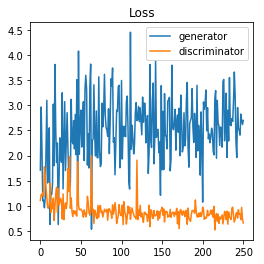


Took:  208.13299870491028  seconds
Epoch : 251 

batch: 0 - loss_d: 0.6874 - loss_g: 2.6697 - loss_real: 0.5101 - loss_fake: 0.1773
batch: 25 - loss_d: 0.8595 - loss_g: 3.3691 - loss_real: 0.5508 - loss_fake: 0.3087
batch: 50 - loss_d: 0.8067 - loss_g: 2.9489 - loss_real: 0.4906 - loss_fake: 0.3161
batch: 75 - loss_d: 0.9081 - loss_g: 2.6411 - loss_real: 0.5031 - loss_fake: 0.4050
batch: 100 - loss_d: 0.8253 - loss_g: 3.0158 - loss_real: 0.5179 - loss_fake: 0.3074
batch: 125 - loss_d: 0.7216 - loss_g: 2.9248 - loss_real: 0.4967 - loss_fake: 0.2249
batch: 150 - loss_d: 0.7143 - loss_g: 2.4513 - loss_real: 0.4617 - loss_fake: 0.2526
batch: 175 - loss_d: 0.6158 - loss_g: 3.0956 - loss_real: 0.4564 - loss_fake: 0.1594
batch: 200 - loss_d: 0.7427 - loss_g: 2.0830 - loss_real: 0.4909 - loss_fake: 0.2517
batch: 225 - loss_d: 0.8493 - loss_g: 3.1782 - loss_real: 0.5062 - loss_fake: 0.3431
batch: 250 - loss_d: 0.8245 - loss_g: 2.6329 - loss_real: 0.4867 - loss_fake: 0.3378
batch: 275 - loss_d:

batch: 50 - loss_d: 0.9343 - loss_g: 3.1971 - loss_real: 0.5273 - loss_fake: 0.4070
batch: 75 - loss_d: 0.7280 - loss_g: 3.0904 - loss_real: 0.4656 - loss_fake: 0.2624
batch: 100 - loss_d: 0.8425 - loss_g: 2.4932 - loss_real: 0.4744 - loss_fake: 0.3681
batch: 125 - loss_d: 0.6970 - loss_g: 3.0241 - loss_real: 0.4894 - loss_fake: 0.2076
batch: 150 - loss_d: 0.7277 - loss_g: 1.7454 - loss_real: 0.4642 - loss_fake: 0.2634
batch: 175 - loss_d: 1.0241 - loss_g: 3.4129 - loss_real: 0.5030 - loss_fake: 0.5211
batch: 200 - loss_d: 0.7397 - loss_g: 2.3696 - loss_real: 0.4772 - loss_fake: 0.2626
batch: 225 - loss_d: 0.7244 - loss_g: 2.6945 - loss_real: 0.4643 - loss_fake: 0.2601
batch: 250 - loss_d: 0.7671 - loss_g: 2.6200 - loss_real: 0.5115 - loss_fake: 0.2556
batch: 275 - loss_d: 0.7862 - loss_g: 2.8480 - loss_real: 0.4556 - loss_fake: 0.3306
batch: 300 - loss_d: 0.8513 - loss_g: 2.1903 - loss_real: 0.5002 - loss_fake: 0.3511

D_loss: 0.9079586267471313; G_loss: 1.7431367635726929
Lowest G lo

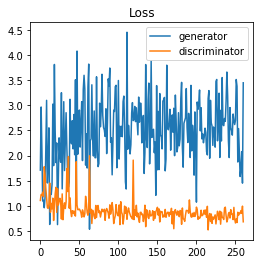


Took:  208.03284788131714  seconds
Epoch : 261 

batch: 0 - loss_d: 0.6931 - loss_g: 3.1651 - loss_real: 0.5379 - loss_fake: 0.1552
batch: 25 - loss_d: 0.7307 - loss_g: 2.2085 - loss_real: 0.4769 - loss_fake: 0.2538
batch: 50 - loss_d: 0.7760 - loss_g: 2.5332 - loss_real: 0.4894 - loss_fake: 0.2866
batch: 75 - loss_d: 0.8611 - loss_g: 2.3018 - loss_real: 0.5145 - loss_fake: 0.3466
batch: 100 - loss_d: 0.9715 - loss_g: 2.0736 - loss_real: 0.5521 - loss_fake: 0.4194
batch: 125 - loss_d: 0.8014 - loss_g: 2.7816 - loss_real: 0.4898 - loss_fake: 0.3116
batch: 150 - loss_d: 0.7539 - loss_g: 2.2808 - loss_real: 0.5039 - loss_fake: 0.2499
batch: 175 - loss_d: 0.7873 - loss_g: 2.3886 - loss_real: 0.5265 - loss_fake: 0.2608
batch: 200 - loss_d: 0.8430 - loss_g: 2.8350 - loss_real: 0.5059 - loss_fake: 0.3371
batch: 225 - loss_d: 0.8280 - loss_g: 2.7503 - loss_real: 0.5046 - loss_fake: 0.3234
batch: 250 - loss_d: 0.7091 - loss_g: 2.8852 - loss_real: 0.4889 - loss_fake: 0.2202
batch: 275 - loss_d:

batch: 50 - loss_d: 0.9646 - loss_g: 2.7481 - loss_real: 0.5321 - loss_fake: 0.4326
batch: 75 - loss_d: 0.7755 - loss_g: 3.0767 - loss_real: 0.5413 - loss_fake: 0.2342
batch: 100 - loss_d: 0.7966 - loss_g: 3.2320 - loss_real: 0.5226 - loss_fake: 0.2740
batch: 125 - loss_d: 0.7114 - loss_g: 2.7651 - loss_real: 0.4821 - loss_fake: 0.2293
batch: 150 - loss_d: 0.8520 - loss_g: 2.5434 - loss_real: 0.5294 - loss_fake: 0.3226
batch: 175 - loss_d: 0.7649 - loss_g: 3.1245 - loss_real: 0.5205 - loss_fake: 0.2444
batch: 200 - loss_d: 0.7984 - loss_g: 3.2158 - loss_real: 0.5264 - loss_fake: 0.2720
batch: 225 - loss_d: 0.7466 - loss_g: 2.6961 - loss_real: 0.4496 - loss_fake: 0.2970
batch: 250 - loss_d: 0.8327 - loss_g: 2.4842 - loss_real: 0.5132 - loss_fake: 0.3195
batch: 275 - loss_d: 0.6175 - loss_g: 2.2194 - loss_real: 0.4408 - loss_fake: 0.1768
batch: 300 - loss_d: 0.8348 - loss_g: 2.0704 - loss_real: 0.4835 - loss_fake: 0.3513

D_loss: 0.9266839623451233; G_loss: 2.602273941040039
Lowest G los

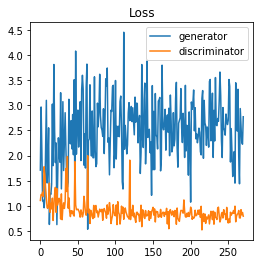


Took:  207.96516799926758  seconds
Epoch : 271 

batch: 0 - loss_d: 0.7990 - loss_g: 2.6565 - loss_real: 0.4592 - loss_fake: 0.3398
batch: 25 - loss_d: 0.7398 - loss_g: 2.9150 - loss_real: 0.5052 - loss_fake: 0.2346
batch: 50 - loss_d: 0.7926 - loss_g: 2.4145 - loss_real: 0.4602 - loss_fake: 0.3324
batch: 75 - loss_d: 0.9582 - loss_g: 2.0579 - loss_real: 0.5286 - loss_fake: 0.4296
batch: 100 - loss_d: 0.8133 - loss_g: 3.0002 - loss_real: 0.5017 - loss_fake: 0.3116
batch: 125 - loss_d: 0.8051 - loss_g: 2.2168 - loss_real: 0.4812 - loss_fake: 0.3239
batch: 150 - loss_d: 0.8241 - loss_g: 2.5410 - loss_real: 0.5075 - loss_fake: 0.3166
batch: 175 - loss_d: 0.7695 - loss_g: 3.5200 - loss_real: 0.5124 - loss_fake: 0.2572
batch: 200 - loss_d: 0.7978 - loss_g: 2.9590 - loss_real: 0.4815 - loss_fake: 0.3163
batch: 225 - loss_d: 0.8083 - loss_g: 2.6356 - loss_real: 0.4857 - loss_fake: 0.3226
batch: 250 - loss_d: 0.7825 - loss_g: 2.5475 - loss_real: 0.5019 - loss_fake: 0.2807
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7897 - loss_g: 2.2291 - loss_real: 0.4704 - loss_fake: 0.3192
batch: 75 - loss_d: 0.8002 - loss_g: 2.1273 - loss_real: 0.4604 - loss_fake: 0.3398
batch: 100 - loss_d: 0.8660 - loss_g: 1.5792 - loss_real: 0.4760 - loss_fake: 0.3900
batch: 125 - loss_d: 0.8394 - loss_g: 2.8258 - loss_real: 0.5177 - loss_fake: 0.3218
batch: 150 - loss_d: 0.8397 - loss_g: 2.6646 - loss_real: 0.5062 - loss_fake: 0.3334
batch: 175 - loss_d: 0.8525 - loss_g: 1.8110 - loss_real: 0.5067 - loss_fake: 0.3458
batch: 200 - loss_d: 0.7858 - loss_g: 3.1966 - loss_real: 0.5162 - loss_fake: 0.2696
batch: 225 - loss_d: 0.6789 - loss_g: 2.7878 - loss_real: 0.4836 - loss_fake: 0.1953
batch: 250 - loss_d: 0.7352 - loss_g: 2.4235 - loss_real: 0.4890 - loss_fake: 0.2462
batch: 275 - loss_d: 0.7269 - loss_g: 2.7221 - loss_real: 0.5147 - loss_fake: 0.2121
batch: 300 - loss_d: 0.7079 - loss_g: 2.3913 - loss_real: 0.4961 - loss_fake: 0.2117

D_loss: 0.6561772227287292; G_loss: 2.8775362968444824
Lowest G lo

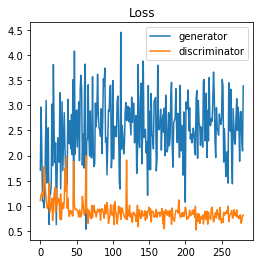


Took:  208.12448358535767  seconds
Epoch : 281 

batch: 0 - loss_d: 0.7534 - loss_g: 2.6617 - loss_real: 0.5010 - loss_fake: 0.2524
batch: 25 - loss_d: 0.8237 - loss_g: 2.4121 - loss_real: 0.5193 - loss_fake: 0.3043
batch: 50 - loss_d: 0.7147 - loss_g: 3.0049 - loss_real: 0.5134 - loss_fake: 0.2013
batch: 75 - loss_d: 0.6369 - loss_g: 3.4395 - loss_real: 0.4934 - loss_fake: 0.1435
batch: 100 - loss_d: 0.8175 - loss_g: 1.9693 - loss_real: 0.4751 - loss_fake: 0.3424
batch: 125 - loss_d: 0.7860 - loss_g: 2.6095 - loss_real: 0.4873 - loss_fake: 0.2986
batch: 150 - loss_d: 0.9553 - loss_g: 2.5176 - loss_real: 0.5265 - loss_fake: 0.4288
batch: 175 - loss_d: 0.7964 - loss_g: 2.5357 - loss_real: 0.5192 - loss_fake: 0.2772
batch: 200 - loss_d: 0.7913 - loss_g: 3.2148 - loss_real: 0.5362 - loss_fake: 0.2551
batch: 225 - loss_d: 0.7134 - loss_g: 2.2449 - loss_real: 0.5232 - loss_fake: 0.1903
batch: 250 - loss_d: 0.8604 - loss_g: 2.9383 - loss_real: 0.5296 - loss_fake: 0.3308
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7930 - loss_g: 2.9050 - loss_real: 0.5012 - loss_fake: 0.2918
batch: 75 - loss_d: 0.7673 - loss_g: 2.9634 - loss_real: 0.5358 - loss_fake: 0.2315
batch: 100 - loss_d: 0.8185 - loss_g: 2.7184 - loss_real: 0.4799 - loss_fake: 0.3387
batch: 125 - loss_d: 0.8473 - loss_g: 2.6426 - loss_real: 0.4993 - loss_fake: 0.3480
batch: 150 - loss_d: 0.6686 - loss_g: 3.2062 - loss_real: 0.4880 - loss_fake: 0.1806
batch: 175 - loss_d: 0.8046 - loss_g: 2.6248 - loss_real: 0.5226 - loss_fake: 0.2820
batch: 200 - loss_d: 0.8036 - loss_g: 2.9101 - loss_real: 0.5147 - loss_fake: 0.2889
batch: 225 - loss_d: 0.7043 - loss_g: 2.4773 - loss_real: 0.5161 - loss_fake: 0.1882
batch: 250 - loss_d: 0.7208 - loss_g: 3.4252 - loss_real: 0.4873 - loss_fake: 0.2335
batch: 275 - loss_d: 0.5878 - loss_g: 3.2451 - loss_real: 0.4842 - loss_fake: 0.1036
batch: 300 - loss_d: 0.8261 - loss_g: 2.0476 - loss_real: 0.4951 - loss_fake: 0.3311

D_loss: 0.7064859867095947; G_loss: 2.6557414531707764
Lowest G lo

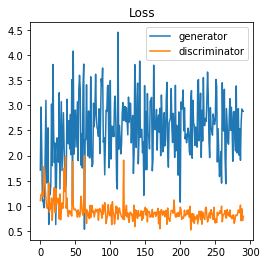


Took:  208.26061701774597  seconds
Epoch : 291 

batch: 0 - loss_d: 0.7160 - loss_g: 2.4458 - loss_real: 0.4743 - loss_fake: 0.2417
batch: 25 - loss_d: 0.7687 - loss_g: 1.8023 - loss_real: 0.5373 - loss_fake: 0.2313
batch: 50 - loss_d: 0.8192 - loss_g: 2.5815 - loss_real: 0.4908 - loss_fake: 0.3284
batch: 75 - loss_d: 0.6576 - loss_g: 2.5948 - loss_real: 0.4272 - loss_fake: 0.2304
batch: 100 - loss_d: 0.7019 - loss_g: 3.0057 - loss_real: 0.4904 - loss_fake: 0.2115
batch: 125 - loss_d: 0.8971 - loss_g: 3.0216 - loss_real: 0.5983 - loss_fake: 0.2988
batch: 150 - loss_d: 0.7368 - loss_g: 2.9960 - loss_real: 0.4760 - loss_fake: 0.2608
batch: 175 - loss_d: 0.7745 - loss_g: 2.4307 - loss_real: 0.4878 - loss_fake: 0.2867
batch: 200 - loss_d: 0.8013 - loss_g: 2.2675 - loss_real: 0.4855 - loss_fake: 0.3158
batch: 225 - loss_d: 0.7415 - loss_g: 2.7621 - loss_real: 0.5120 - loss_fake: 0.2295
batch: 250 - loss_d: 0.7173 - loss_g: 3.4935 - loss_real: 0.4946 - loss_fake: 0.2227
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7233 - loss_g: 2.8136 - loss_real: 0.4762 - loss_fake: 0.2471
batch: 75 - loss_d: 0.6586 - loss_g: 3.5230 - loss_real: 0.5059 - loss_fake: 0.1527
batch: 100 - loss_d: 0.8623 - loss_g: 2.1491 - loss_real: 0.4946 - loss_fake: 0.3677
batch: 125 - loss_d: 0.6980 - loss_g: 2.9283 - loss_real: 0.4750 - loss_fake: 0.2230
batch: 150 - loss_d: 0.8625 - loss_g: 2.1558 - loss_real: 0.5050 - loss_fake: 0.3575
batch: 175 - loss_d: 0.7821 - loss_g: 2.4586 - loss_real: 0.4528 - loss_fake: 0.3293
batch: 200 - loss_d: 0.7590 - loss_g: 2.2960 - loss_real: 0.5261 - loss_fake: 0.2329
batch: 225 - loss_d: 0.8371 - loss_g: 2.6350 - loss_real: 0.4912 - loss_fake: 0.3459
batch: 250 - loss_d: 0.8504 - loss_g: 2.4196 - loss_real: 0.5110 - loss_fake: 0.3394
batch: 275 - loss_d: 0.8077 - loss_g: 2.6691 - loss_real: 0.5233 - loss_fake: 0.2844
batch: 300 - loss_d: 0.8177 - loss_g: 2.5041 - loss_real: 0.5019 - loss_fake: 0.3157

D_loss: 0.8373347520828247; G_loss: 3.4069788455963135
Lowest G lo

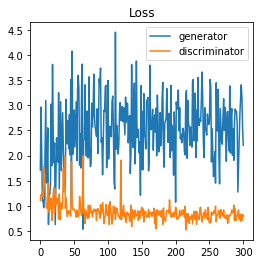


Took:  208.19762635231018  seconds
Epoch : 301 

batch: 0 - loss_d: 0.7666 - loss_g: 3.3258 - loss_real: 0.5279 - loss_fake: 0.2388
batch: 25 - loss_d: 0.7685 - loss_g: 2.3538 - loss_real: 0.4985 - loss_fake: 0.2700
batch: 50 - loss_d: 0.7510 - loss_g: 3.0835 - loss_real: 0.5376 - loss_fake: 0.2133
batch: 75 - loss_d: 0.6940 - loss_g: 2.7943 - loss_real: 0.4546 - loss_fake: 0.2395
batch: 100 - loss_d: 0.7927 - loss_g: 3.3294 - loss_real: 0.5227 - loss_fake: 0.2700
batch: 125 - loss_d: 0.7239 - loss_g: 2.7328 - loss_real: 0.4781 - loss_fake: 0.2458
batch: 150 - loss_d: 0.8403 - loss_g: 2.6845 - loss_real: 0.5271 - loss_fake: 0.3131
batch: 175 - loss_d: 0.7020 - loss_g: 2.6862 - loss_real: 0.5242 - loss_fake: 0.1778
batch: 200 - loss_d: 0.6669 - loss_g: 2.6476 - loss_real: 0.4590 - loss_fake: 0.2079
batch: 225 - loss_d: 0.8699 - loss_g: 2.7955 - loss_real: 0.5106 - loss_fake: 0.3593
batch: 250 - loss_d: 0.7503 - loss_g: 2.7451 - loss_real: 0.5015 - loss_fake: 0.2488
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7862 - loss_g: 2.6250 - loss_real: 0.4867 - loss_fake: 0.2996
batch: 75 - loss_d: 0.6846 - loss_g: 3.1036 - loss_real: 0.4896 - loss_fake: 0.1950
batch: 100 - loss_d: 0.7067 - loss_g: 3.1261 - loss_real: 0.5123 - loss_fake: 0.1944
batch: 125 - loss_d: 0.7474 - loss_g: 2.9518 - loss_real: 0.4397 - loss_fake: 0.3076
batch: 150 - loss_d: 0.8438 - loss_g: 3.4532 - loss_real: 0.5031 - loss_fake: 0.3407
batch: 175 - loss_d: 0.7089 - loss_g: 2.8879 - loss_real: 0.5105 - loss_fake: 0.1984
batch: 200 - loss_d: 0.5964 - loss_g: 3.2003 - loss_real: 0.4787 - loss_fake: 0.1178
batch: 225 - loss_d: 0.8214 - loss_g: 3.0254 - loss_real: 0.5433 - loss_fake: 0.2781
batch: 250 - loss_d: 0.7638 - loss_g: 2.8621 - loss_real: 0.4530 - loss_fake: 0.3107
batch: 275 - loss_d: 0.7151 - loss_g: 2.5169 - loss_real: 0.4527 - loss_fake: 0.2624
batch: 300 - loss_d: 0.8582 - loss_g: 2.5073 - loss_real: 0.5003 - loss_fake: 0.3579

D_loss: 0.75145423412323; G_loss: 2.7349555492401123
Lowest G loss

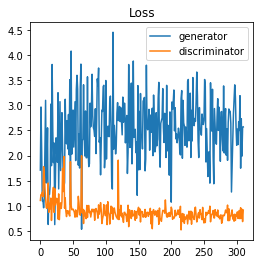


Took:  208.1354944705963  seconds
Epoch : 311 

batch: 0 - loss_d: 0.7775 - loss_g: 2.4158 - loss_real: 0.5163 - loss_fake: 0.2612
batch: 25 - loss_d: 0.8548 - loss_g: 2.4703 - loss_real: 0.5310 - loss_fake: 0.3237
batch: 50 - loss_d: 0.7765 - loss_g: 2.8450 - loss_real: 0.4775 - loss_fake: 0.2990
batch: 75 - loss_d: 0.7465 - loss_g: 2.1791 - loss_real: 0.4693 - loss_fake: 0.2772
batch: 100 - loss_d: 0.8651 - loss_g: 2.2519 - loss_real: 0.5207 - loss_fake: 0.3444
batch: 125 - loss_d: 0.7382 - loss_g: 2.2553 - loss_real: 0.4951 - loss_fake: 0.2431
batch: 150 - loss_d: 0.8097 - loss_g: 2.8058 - loss_real: 0.5035 - loss_fake: 0.3062
batch: 175 - loss_d: 0.6948 - loss_g: 2.8665 - loss_real: 0.4855 - loss_fake: 0.2093
batch: 200 - loss_d: 0.7297 - loss_g: 2.7875 - loss_real: 0.4896 - loss_fake: 0.2401
batch: 225 - loss_d: 0.7723 - loss_g: 3.4512 - loss_real: 0.5459 - loss_fake: 0.2264
batch: 250 - loss_d: 0.7607 - loss_g: 1.6979 - loss_real: 0.4905 - loss_fake: 0.2702
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.7946 - loss_g: 2.9080 - loss_real: 0.5155 - loss_fake: 0.2790
batch: 75 - loss_d: 0.6961 - loss_g: 2.7714 - loss_real: 0.4407 - loss_fake: 0.2555
batch: 100 - loss_d: 0.8036 - loss_g: 2.6392 - loss_real: 0.4990 - loss_fake: 0.3045
batch: 125 - loss_d: 0.7828 - loss_g: 3.0256 - loss_real: 0.5311 - loss_fake: 0.2517
batch: 150 - loss_d: 0.8348 - loss_g: 2.2248 - loss_real: 0.4432 - loss_fake: 0.3915
batch: 175 - loss_d: 0.6950 - loss_g: 2.6775 - loss_real: 0.5013 - loss_fake: 0.1937
batch: 200 - loss_d: 0.7711 - loss_g: 2.8078 - loss_real: 0.4920 - loss_fake: 0.2791
batch: 225 - loss_d: 0.7933 - loss_g: 2.6570 - loss_real: 0.4943 - loss_fake: 0.2990
batch: 250 - loss_d: 0.9040 - loss_g: 2.4419 - loss_real: 0.5046 - loss_fake: 0.3995
batch: 275 - loss_d: 0.8973 - loss_g: 2.9880 - loss_real: 0.6139 - loss_fake: 0.2834
batch: 300 - loss_d: 0.8763 - loss_g: 1.9249 - loss_real: 0.5227 - loss_fake: 0.3536

D_loss: 0.8333921432495117; G_loss: 3.306551933288574
Lowest G los

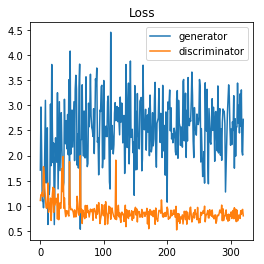


Took:  208.30182433128357  seconds
Epoch : 321 

batch: 0 - loss_d: 0.7960 - loss_g: 2.7745 - loss_real: 0.5011 - loss_fake: 0.2949
batch: 25 - loss_d: 0.6602 - loss_g: 2.3809 - loss_real: 0.4665 - loss_fake: 0.1937
batch: 50 - loss_d: 0.8219 - loss_g: 2.4429 - loss_real: 0.4896 - loss_fake: 0.3324
batch: 75 - loss_d: 0.7586 - loss_g: 1.9772 - loss_real: 0.4590 - loss_fake: 0.2996
batch: 100 - loss_d: 0.7417 - loss_g: 2.3521 - loss_real: 0.4698 - loss_fake: 0.2719
batch: 125 - loss_d: 0.7928 - loss_g: 2.6479 - loss_real: 0.5013 - loss_fake: 0.2916
batch: 150 - loss_d: 0.7475 - loss_g: 2.4737 - loss_real: 0.4775 - loss_fake: 0.2700
batch: 175 - loss_d: 0.7883 - loss_g: 2.3878 - loss_real: 0.4971 - loss_fake: 0.2912
batch: 200 - loss_d: 0.8231 - loss_g: 2.5703 - loss_real: 0.4566 - loss_fake: 0.3666
batch: 225 - loss_d: 0.7027 - loss_g: 2.9182 - loss_real: 0.4740 - loss_fake: 0.2286
batch: 250 - loss_d: 0.6602 - loss_g: 2.7005 - loss_real: 0.4757 - loss_fake: 0.1845
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7945 - loss_g: 2.2780 - loss_real: 0.4902 - loss_fake: 0.3044
batch: 75 - loss_d: 0.7472 - loss_g: 3.2792 - loss_real: 0.5497 - loss_fake: 0.1975
batch: 100 - loss_d: 0.7708 - loss_g: 2.4213 - loss_real: 0.4766 - loss_fake: 0.2942
batch: 125 - loss_d: 0.5994 - loss_g: 3.5915 - loss_real: 0.4625 - loss_fake: 0.1369
batch: 150 - loss_d: 0.7289 - loss_g: 2.6402 - loss_real: 0.4637 - loss_fake: 0.2652
batch: 175 - loss_d: 0.7253 - loss_g: 2.8898 - loss_real: 0.5037 - loss_fake: 0.2217
batch: 200 - loss_d: 0.8135 - loss_g: 2.2643 - loss_real: 0.4917 - loss_fake: 0.3219
batch: 225 - loss_d: 0.6087 - loss_g: 3.2665 - loss_real: 0.4617 - loss_fake: 0.1470
batch: 250 - loss_d: 0.7506 - loss_g: 2.9988 - loss_real: 0.4518 - loss_fake: 0.2988
batch: 275 - loss_d: 0.8028 - loss_g: 2.3998 - loss_real: 0.4829 - loss_fake: 0.3199
batch: 300 - loss_d: 0.6931 - loss_g: 2.9576 - loss_real: 0.5107 - loss_fake: 0.1824

D_loss: 0.6115700602531433; G_loss: 3.4615886211395264
Lowest G lo

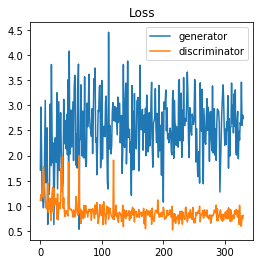


Took:  208.16809725761414  seconds
Epoch : 331 

batch: 0 - loss_d: 0.8287 - loss_g: 2.6790 - loss_real: 0.4840 - loss_fake: 0.3446
batch: 25 - loss_d: 0.7142 - loss_g: 2.6016 - loss_real: 0.4484 - loss_fake: 0.2658
batch: 50 - loss_d: 0.6481 - loss_g: 3.4251 - loss_real: 0.4645 - loss_fake: 0.1836
batch: 75 - loss_d: 0.7828 - loss_g: 2.8644 - loss_real: 0.5134 - loss_fake: 0.2693
batch: 100 - loss_d: 0.8698 - loss_g: 2.7808 - loss_real: 0.5141 - loss_fake: 0.3557
batch: 125 - loss_d: 0.7076 - loss_g: 2.9787 - loss_real: 0.5073 - loss_fake: 0.2003
batch: 150 - loss_d: 0.7726 - loss_g: 2.7857 - loss_real: 0.5371 - loss_fake: 0.2355
batch: 175 - loss_d: 0.7361 - loss_g: 3.0827 - loss_real: 0.4941 - loss_fake: 0.2420
batch: 200 - loss_d: 0.9204 - loss_g: 2.0768 - loss_real: 0.5414 - loss_fake: 0.3790
batch: 225 - loss_d: 0.8390 - loss_g: 2.4479 - loss_real: 0.5363 - loss_fake: 0.3028
batch: 250 - loss_d: 0.7673 - loss_g: 2.7764 - loss_real: 0.4989 - loss_fake: 0.2684
batch: 275 - loss_d:

batch: 50 - loss_d: 0.8229 - loss_g: 2.1196 - loss_real: 0.5021 - loss_fake: 0.3208
batch: 75 - loss_d: 0.8426 - loss_g: 3.4564 - loss_real: 0.5445 - loss_fake: 0.2981
batch: 100 - loss_d: 0.8535 - loss_g: 2.4671 - loss_real: 0.5298 - loss_fake: 0.3237
batch: 125 - loss_d: 0.6628 - loss_g: 2.4369 - loss_real: 0.4476 - loss_fake: 0.2152
batch: 150 - loss_d: 0.9493 - loss_g: 2.2555 - loss_real: 0.5301 - loss_fake: 0.4191
batch: 175 - loss_d: 0.7785 - loss_g: 2.6686 - loss_real: 0.4496 - loss_fake: 0.3288
batch: 200 - loss_d: 0.8800 - loss_g: 2.5130 - loss_real: 0.5087 - loss_fake: 0.3713
batch: 225 - loss_d: 0.6427 - loss_g: 3.0119 - loss_real: 0.5026 - loss_fake: 0.1401
batch: 250 - loss_d: 0.7324 - loss_g: 2.6185 - loss_real: 0.4742 - loss_fake: 0.2582
batch: 275 - loss_d: 0.8312 - loss_g: 2.6027 - loss_real: 0.5172 - loss_fake: 0.3141
batch: 300 - loss_d: 0.7178 - loss_g: 3.1302 - loss_real: 0.5197 - loss_fake: 0.1981

D_loss: 0.8786455988883972; G_loss: 3.5945518016815186
Lowest G lo

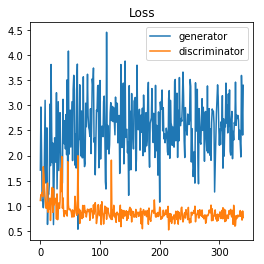


Took:  208.35738468170166  seconds
Epoch : 341 

batch: 0 - loss_d: 0.6786 - loss_g: 3.2283 - loss_real: 0.4679 - loss_fake: 0.2107
batch: 25 - loss_d: 0.6946 - loss_g: 3.5944 - loss_real: 0.4567 - loss_fake: 0.2379
batch: 50 - loss_d: 0.7466 - loss_g: 3.0995 - loss_real: 0.5055 - loss_fake: 0.2411
batch: 75 - loss_d: 0.7032 - loss_g: 2.1663 - loss_real: 0.4416 - loss_fake: 0.2616
batch: 100 - loss_d: 0.6672 - loss_g: 2.9154 - loss_real: 0.5032 - loss_fake: 0.1640
batch: 125 - loss_d: 0.6831 - loss_g: 2.8345 - loss_real: 0.5035 - loss_fake: 0.1796
batch: 150 - loss_d: 0.8059 - loss_g: 2.3013 - loss_real: 0.5088 - loss_fake: 0.2972
batch: 175 - loss_d: 0.8005 - loss_g: 2.9089 - loss_real: 0.5044 - loss_fake: 0.2961
batch: 200 - loss_d: 0.6779 - loss_g: 2.6728 - loss_real: 0.4518 - loss_fake: 0.2262
batch: 225 - loss_d: 0.7282 - loss_g: 3.1565 - loss_real: 0.4626 - loss_fake: 0.2656
batch: 250 - loss_d: 0.7518 - loss_g: 2.7569 - loss_real: 0.4529 - loss_fake: 0.2989
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7779 - loss_g: 2.2992 - loss_real: 0.4890 - loss_fake: 0.2890
batch: 75 - loss_d: 0.6697 - loss_g: 2.6551 - loss_real: 0.4378 - loss_fake: 0.2318
batch: 100 - loss_d: 0.8969 - loss_g: 2.2540 - loss_real: 0.5057 - loss_fake: 0.3912
batch: 125 - loss_d: 0.8731 - loss_g: 2.3649 - loss_real: 0.4814 - loss_fake: 0.3916
batch: 150 - loss_d: 0.7742 - loss_g: 2.9579 - loss_real: 0.4758 - loss_fake: 0.2984
batch: 175 - loss_d: 0.6503 - loss_g: 3.0205 - loss_real: 0.4543 - loss_fake: 0.1961
batch: 200 - loss_d: 0.6717 - loss_g: 2.9275 - loss_real: 0.5190 - loss_fake: 0.1528
batch: 225 - loss_d: 0.7283 - loss_g: 2.6205 - loss_real: 0.4662 - loss_fake: 0.2621
batch: 250 - loss_d: 0.7544 - loss_g: 2.8358 - loss_real: 0.4922 - loss_fake: 0.2622
batch: 275 - loss_d: 0.8121 - loss_g: 2.6220 - loss_real: 0.5200 - loss_fake: 0.2921
batch: 300 - loss_d: 0.8211 - loss_g: 2.5470 - loss_real: 0.4988 - loss_fake: 0.3223

D_loss: 0.8123464584350586; G_loss: 2.491905927658081
Lowest G los

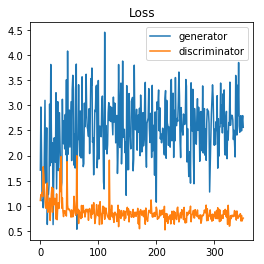


Took:  208.20429515838623  seconds
Epoch : 351 

batch: 0 - loss_d: 0.8458 - loss_g: 2.5683 - loss_real: 0.5002 - loss_fake: 0.3456
batch: 25 - loss_d: 0.7702 - loss_g: 3.1992 - loss_real: 0.5080 - loss_fake: 0.2622
batch: 50 - loss_d: 0.7940 - loss_g: 2.4209 - loss_real: 0.4905 - loss_fake: 0.3035
batch: 75 - loss_d: 0.7876 - loss_g: 2.3980 - loss_real: 0.4512 - loss_fake: 0.3364
batch: 100 - loss_d: 0.7186 - loss_g: 2.9598 - loss_real: 0.4749 - loss_fake: 0.2437
batch: 125 - loss_d: 0.8245 - loss_g: 2.4957 - loss_real: 0.5212 - loss_fake: 0.3033
batch: 150 - loss_d: 0.7485 - loss_g: 2.9391 - loss_real: 0.4974 - loss_fake: 0.2511
batch: 175 - loss_d: 0.6812 - loss_g: 3.0695 - loss_real: 0.4804 - loss_fake: 0.2009
batch: 200 - loss_d: 0.7075 - loss_g: 3.9318 - loss_real: 0.5077 - loss_fake: 0.1999
batch: 225 - loss_d: 0.6768 - loss_g: 3.4488 - loss_real: 0.5026 - loss_fake: 0.1742
batch: 250 - loss_d: 0.7583 - loss_g: 2.5637 - loss_real: 0.4935 - loss_fake: 0.2648
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7744 - loss_g: 4.1591 - loss_real: 0.5067 - loss_fake: 0.2677
batch: 75 - loss_d: 0.7422 - loss_g: 2.5196 - loss_real: 0.4656 - loss_fake: 0.2766
batch: 100 - loss_d: 0.6889 - loss_g: 2.7261 - loss_real: 0.4515 - loss_fake: 0.2374
batch: 125 - loss_d: 0.7609 - loss_g: 2.7438 - loss_real: 0.5018 - loss_fake: 0.2591
batch: 150 - loss_d: 0.7895 - loss_g: 2.6977 - loss_real: 0.4707 - loss_fake: 0.3188
batch: 175 - loss_d: 0.8247 - loss_g: 2.9561 - loss_real: 0.5204 - loss_fake: 0.3043
batch: 200 - loss_d: 0.7059 - loss_g: 2.7889 - loss_real: 0.4820 - loss_fake: 0.2239
batch: 225 - loss_d: 0.6572 - loss_g: 2.4922 - loss_real: 0.4266 - loss_fake: 0.2306
batch: 250 - loss_d: 0.7106 - loss_g: 3.1312 - loss_real: 0.4988 - loss_fake: 0.2118
batch: 275 - loss_d: 0.7216 - loss_g: 2.7356 - loss_real: 0.5067 - loss_fake: 0.2149
batch: 300 - loss_d: 0.7831 - loss_g: 2.4883 - loss_real: 0.4863 - loss_fake: 0.2969

D_loss: 0.8103737831115723; G_loss: 3.0863184928894043
Lowest G lo

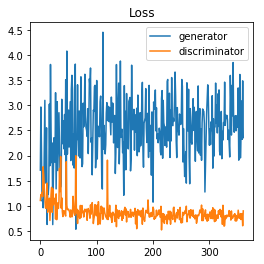


Took:  208.2929825782776  seconds
Epoch : 361 

batch: 0 - loss_d: 0.7611 - loss_g: 2.3396 - loss_real: 0.5000 - loss_fake: 0.2611
batch: 25 - loss_d: 0.7634 - loss_g: 2.6715 - loss_real: 0.4988 - loss_fake: 0.2646
batch: 50 - loss_d: 0.8450 - loss_g: 2.4790 - loss_real: 0.5020 - loss_fake: 0.3430
batch: 75 - loss_d: 0.7890 - loss_g: 3.0892 - loss_real: 0.5013 - loss_fake: 0.2877
batch: 100 - loss_d: 0.8012 - loss_g: 2.4618 - loss_real: 0.4965 - loss_fake: 0.3047
batch: 125 - loss_d: 0.7700 - loss_g: 2.9490 - loss_real: 0.5146 - loss_fake: 0.2555
batch: 150 - loss_d: 0.6621 - loss_g: 2.6666 - loss_real: 0.4779 - loss_fake: 0.1842
batch: 175 - loss_d: 0.7502 - loss_g: 2.8490 - loss_real: 0.4860 - loss_fake: 0.2642
batch: 200 - loss_d: 0.7904 - loss_g: 2.7538 - loss_real: 0.5186 - loss_fake: 0.2718
batch: 225 - loss_d: 0.6516 - loss_g: 2.9966 - loss_real: 0.4846 - loss_fake: 0.1671
batch: 250 - loss_d: 0.7573 - loss_g: 2.4883 - loss_real: 0.4447 - loss_fake: 0.3126
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.6830 - loss_g: 2.9617 - loss_real: 0.5273 - loss_fake: 0.1557
batch: 75 - loss_d: 0.7879 - loss_g: 2.4005 - loss_real: 0.4966 - loss_fake: 0.2913
batch: 100 - loss_d: 0.8338 - loss_g: 2.2593 - loss_real: 0.4954 - loss_fake: 0.3384
batch: 125 - loss_d: 0.7515 - loss_g: 2.5508 - loss_real: 0.5017 - loss_fake: 0.2499
batch: 150 - loss_d: 0.8238 - loss_g: 2.3263 - loss_real: 0.4934 - loss_fake: 0.3304
batch: 175 - loss_d: 0.6452 - loss_g: 2.6918 - loss_real: 0.4458 - loss_fake: 0.1994
batch: 200 - loss_d: 0.8378 - loss_g: 2.5061 - loss_real: 0.4957 - loss_fake: 0.3421
batch: 225 - loss_d: 0.6610 - loss_g: 3.0267 - loss_real: 0.4786 - loss_fake: 0.1824
batch: 250 - loss_d: 0.7353 - loss_g: 2.8094 - loss_real: 0.4759 - loss_fake: 0.2594
batch: 275 - loss_d: 0.8437 - loss_g: 2.3239 - loss_real: 0.5318 - loss_fake: 0.3119
batch: 300 - loss_d: 0.7513 - loss_g: 3.5839 - loss_real: 0.4893 - loss_fake: 0.2621

D_loss: 0.8440122604370117; G_loss: 2.122504234313965
Lowest G los

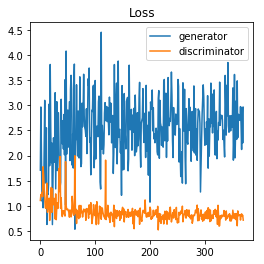


Took:  208.1561951637268  seconds
Epoch : 371 

batch: 0 - loss_d: 0.8404 - loss_g: 2.4533 - loss_real: 0.5031 - loss_fake: 0.3373
batch: 25 - loss_d: 0.8007 - loss_g: 2.3795 - loss_real: 0.4709 - loss_fake: 0.3298
batch: 50 - loss_d: 0.7461 - loss_g: 2.3285 - loss_real: 0.4853 - loss_fake: 0.2608
batch: 75 - loss_d: 0.7805 - loss_g: 2.7221 - loss_real: 0.5213 - loss_fake: 0.2591
batch: 100 - loss_d: 0.7115 - loss_g: 2.7766 - loss_real: 0.4666 - loss_fake: 0.2449
batch: 125 - loss_d: 0.8096 - loss_g: 2.8060 - loss_real: 0.4881 - loss_fake: 0.3215
batch: 150 - loss_d: 0.7080 - loss_g: 2.9388 - loss_real: 0.4865 - loss_fake: 0.2215
batch: 175 - loss_d: 0.7115 - loss_g: 2.4766 - loss_real: 0.4373 - loss_fake: 0.2743
batch: 200 - loss_d: 0.7707 - loss_g: 2.4218 - loss_real: 0.4706 - loss_fake: 0.3002
batch: 225 - loss_d: 0.6523 - loss_g: 2.8946 - loss_real: 0.4965 - loss_fake: 0.1558
batch: 250 - loss_d: 0.7380 - loss_g: 2.7822 - loss_real: 0.4252 - loss_fake: 0.3128
batch: 275 - loss_d: 

batch: 50 - loss_d: 0.6908 - loss_g: 3.1938 - loss_real: 0.4889 - loss_fake: 0.2019
batch: 75 - loss_d: 0.6880 - loss_g: 2.6891 - loss_real: 0.4844 - loss_fake: 0.2037
batch: 100 - loss_d: 0.7614 - loss_g: 2.6831 - loss_real: 0.4799 - loss_fake: 0.2815
batch: 125 - loss_d: 0.7861 - loss_g: 2.7715 - loss_real: 0.4840 - loss_fake: 0.3020
batch: 150 - loss_d: 0.8267 - loss_g: 2.5237 - loss_real: 0.4631 - loss_fake: 0.3636
batch: 175 - loss_d: 0.6845 - loss_g: 2.8810 - loss_real: 0.4570 - loss_fake: 0.2275
batch: 200 - loss_d: 0.7297 - loss_g: 2.5649 - loss_real: 0.4584 - loss_fake: 0.2713
batch: 225 - loss_d: 0.6920 - loss_g: 2.7231 - loss_real: 0.4743 - loss_fake: 0.2177
batch: 250 - loss_d: 0.7725 - loss_g: 2.9235 - loss_real: 0.5020 - loss_fake: 0.2706
batch: 275 - loss_d: 0.7033 - loss_g: 3.1095 - loss_real: 0.5065 - loss_fake: 0.1968
batch: 300 - loss_d: 0.8020 - loss_g: 2.3453 - loss_real: 0.4904 - loss_fake: 0.3115

D_loss: 0.6780047416687012; G_loss: 2.9858689308166504
Lowest G lo

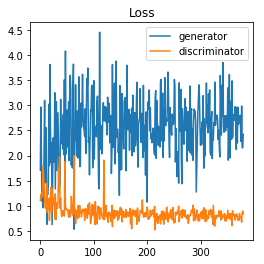


Took:  208.18941140174866  seconds
Epoch : 381 

batch: 0 - loss_d: 0.6818 - loss_g: 2.7622 - loss_real: 0.4965 - loss_fake: 0.1853
batch: 25 - loss_d: 0.7890 - loss_g: 2.6507 - loss_real: 0.4873 - loss_fake: 0.3017
batch: 50 - loss_d: 0.7902 - loss_g: 2.4174 - loss_real: 0.4685 - loss_fake: 0.3217
batch: 75 - loss_d: 0.8102 - loss_g: 2.6717 - loss_real: 0.5169 - loss_fake: 0.2933
batch: 100 - loss_d: 0.8263 - loss_g: 2.3738 - loss_real: 0.4837 - loss_fake: 0.3425
batch: 125 - loss_d: 0.8504 - loss_g: 2.5413 - loss_real: 0.4859 - loss_fake: 0.3645
batch: 150 - loss_d: 0.7526 - loss_g: 2.6336 - loss_real: 0.4828 - loss_fake: 0.2697
batch: 175 - loss_d: 0.7659 - loss_g: 2.8474 - loss_real: 0.4843 - loss_fake: 0.2816
batch: 200 - loss_d: 0.8474 - loss_g: 2.4495 - loss_real: 0.4834 - loss_fake: 0.3640
batch: 225 - loss_d: 0.7650 - loss_g: 2.8266 - loss_real: 0.4841 - loss_fake: 0.2809
batch: 250 - loss_d: 0.8693 - loss_g: 2.0064 - loss_real: 0.5392 - loss_fake: 0.3302
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7822 - loss_g: 2.5569 - loss_real: 0.4238 - loss_fake: 0.3584
batch: 75 - loss_d: 0.7233 - loss_g: 3.2850 - loss_real: 0.4773 - loss_fake: 0.2460
batch: 100 - loss_d: 0.8541 - loss_g: 2.4377 - loss_real: 0.5409 - loss_fake: 0.3132
batch: 125 - loss_d: 0.7424 - loss_g: 2.5392 - loss_real: 0.4949 - loss_fake: 0.2475
batch: 150 - loss_d: 0.6382 - loss_g: 3.2537 - loss_real: 0.4926 - loss_fake: 0.1455
batch: 175 - loss_d: 0.7274 - loss_g: 2.9007 - loss_real: 0.5005 - loss_fake: 0.2269
batch: 200 - loss_d: 0.5635 - loss_g: 3.1475 - loss_real: 0.4444 - loss_fake: 0.1191
batch: 225 - loss_d: 0.8427 - loss_g: 2.7200 - loss_real: 0.4967 - loss_fake: 0.3460
batch: 250 - loss_d: 0.7572 - loss_g: 2.6826 - loss_real: 0.4832 - loss_fake: 0.2741
batch: 275 - loss_d: 0.8016 - loss_g: 2.3926 - loss_real: 0.4712 - loss_fake: 0.3303
batch: 300 - loss_d: 0.5543 - loss_g: 3.1067 - loss_real: 0.4656 - loss_fake: 0.0887

D_loss: 0.8613160848617554; G_loss: 2.3547980785369873
Lowest G lo

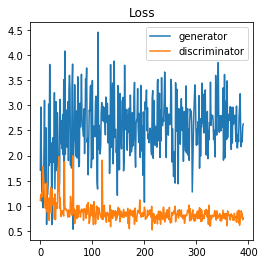


Took:  208.33523845672607  seconds
Epoch : 391 

batch: 0 - loss_d: 0.8932 - loss_g: 2.2753 - loss_real: 0.5215 - loss_fake: 0.3716
batch: 25 - loss_d: 0.7852 - loss_g: 2.4021 - loss_real: 0.5022 - loss_fake: 0.2830
batch: 50 - loss_d: 0.8004 - loss_g: 2.8403 - loss_real: 0.5034 - loss_fake: 0.2970
batch: 75 - loss_d: 0.7527 - loss_g: 2.6542 - loss_real: 0.4738 - loss_fake: 0.2789
batch: 100 - loss_d: 0.7151 - loss_g: 2.8489 - loss_real: 0.4901 - loss_fake: 0.2249
batch: 125 - loss_d: 0.8235 - loss_g: 2.4758 - loss_real: 0.5303 - loss_fake: 0.2932
batch: 150 - loss_d: 0.7412 - loss_g: 2.9639 - loss_real: 0.4780 - loss_fake: 0.2632
batch: 175 - loss_d: 0.6723 - loss_g: 2.8528 - loss_real: 0.4773 - loss_fake: 0.1950
batch: 200 - loss_d: 0.7156 - loss_g: 2.7136 - loss_real: 0.4737 - loss_fake: 0.2419
batch: 225 - loss_d: 0.8248 - loss_g: 2.5614 - loss_real: 0.4783 - loss_fake: 0.3465
batch: 250 - loss_d: 0.8195 - loss_g: 2.3018 - loss_real: 0.5088 - loss_fake: 0.3107
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7339 - loss_g: 2.4286 - loss_real: 0.4801 - loss_fake: 0.2538
batch: 75 - loss_d: 0.8143 - loss_g: 2.1420 - loss_real: 0.4713 - loss_fake: 0.3430
batch: 100 - loss_d: 0.7291 - loss_g: 2.8723 - loss_real: 0.5088 - loss_fake: 0.2203
batch: 125 - loss_d: 0.6455 - loss_g: 3.1212 - loss_real: 0.4789 - loss_fake: 0.1666
batch: 150 - loss_d: 0.9002 - loss_g: 2.7866 - loss_real: 0.5077 - loss_fake: 0.3925
batch: 175 - loss_d: 0.6535 - loss_g: 2.9314 - loss_real: 0.4567 - loss_fake: 0.1967
batch: 200 - loss_d: 0.7603 - loss_g: 2.7181 - loss_real: 0.5045 - loss_fake: 0.2558
batch: 225 - loss_d: 0.7247 - loss_g: 3.0850 - loss_real: 0.4925 - loss_fake: 0.2323
batch: 250 - loss_d: 0.6815 - loss_g: 2.7262 - loss_real: 0.4609 - loss_fake: 0.2206
batch: 275 - loss_d: 0.7406 - loss_g: 2.6856 - loss_real: 0.4857 - loss_fake: 0.2549
batch: 300 - loss_d: 0.7388 - loss_g: 2.5959 - loss_real: 0.4555 - loss_fake: 0.2832

D_loss: 0.7707871794700623; G_loss: 2.4036405086517334
Lowest G lo

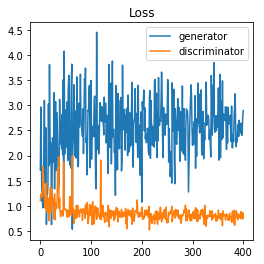


Took:  208.09756565093994  seconds
Epoch : 401 

batch: 0 - loss_d: 0.7384 - loss_g: 2.5243 - loss_real: 0.4984 - loss_fake: 0.2400
batch: 25 - loss_d: 0.8072 - loss_g: 1.9152 - loss_real: 0.4578 - loss_fake: 0.3494
batch: 50 - loss_d: 0.7753 - loss_g: 2.6813 - loss_real: 0.5326 - loss_fake: 0.2427
batch: 75 - loss_d: 0.8988 - loss_g: 2.6531 - loss_real: 0.5064 - loss_fake: 0.3923
batch: 100 - loss_d: 0.7582 - loss_g: 2.5127 - loss_real: 0.4574 - loss_fake: 0.3008
batch: 125 - loss_d: 0.8291 - loss_g: 2.1982 - loss_real: 0.4934 - loss_fake: 0.3357
batch: 150 - loss_d: 0.7357 - loss_g: 2.6489 - loss_real: 0.5188 - loss_fake: 0.2169
batch: 175 - loss_d: 0.8766 - loss_g: 2.1424 - loss_real: 0.5088 - loss_fake: 0.3678
batch: 200 - loss_d: 0.7638 - loss_g: 2.5718 - loss_real: 0.4522 - loss_fake: 0.3116
batch: 225 - loss_d: 0.6798 - loss_g: 2.8530 - loss_real: 0.5073 - loss_fake: 0.1725
batch: 250 - loss_d: 0.7555 - loss_g: 2.4633 - loss_real: 0.5053 - loss_fake: 0.2502
batch: 275 - loss_d:

batch: 50 - loss_d: 0.7466 - loss_g: 2.8662 - loss_real: 0.4928 - loss_fake: 0.2539
batch: 75 - loss_d: 0.8328 - loss_g: 2.3783 - loss_real: 0.5182 - loss_fake: 0.3146
batch: 100 - loss_d: 0.6866 - loss_g: 2.4159 - loss_real: 0.4597 - loss_fake: 0.2269
batch: 125 - loss_d: 0.5918 - loss_g: 3.4656 - loss_real: 0.4759 - loss_fake: 0.1159
batch: 150 - loss_d: 0.8240 - loss_g: 2.6070 - loss_real: 0.5088 - loss_fake: 0.3152
batch: 175 - loss_d: 0.6334 - loss_g: 2.9380 - loss_real: 0.4657 - loss_fake: 0.1677
batch: 200 - loss_d: 0.6929 - loss_g: 2.7345 - loss_real: 0.4913 - loss_fake: 0.2017
batch: 225 - loss_d: 0.7095 - loss_g: 2.5026 - loss_real: 0.4433 - loss_fake: 0.2662
batch: 250 - loss_d: 0.6334 - loss_g: 2.6909 - loss_real: 0.4709 - loss_fake: 0.1625
batch: 275 - loss_d: 0.6398 - loss_g: 3.0166 - loss_real: 0.4732 - loss_fake: 0.1666
batch: 300 - loss_d: 0.7040 - loss_g: 2.7070 - loss_real: 0.4658 - loss_fake: 0.2382

D_loss: 0.7002594470977783; G_loss: 2.738640308380127
Lowest G los

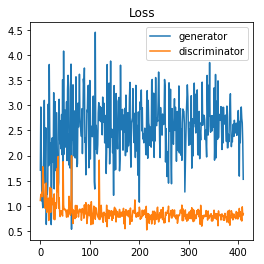


Took:  208.32554173469543  seconds
Epoch : 411 

batch: 0 - loss_d: 0.8554 - loss_g: 3.9957 - loss_real: 0.4723 - loss_fake: 0.3831
batch: 25 - loss_d: 0.7718 - loss_g: 2.6243 - loss_real: 0.4894 - loss_fake: 0.2824
batch: 50 - loss_d: 0.8632 - loss_g: 2.4593 - loss_real: 0.5105 - loss_fake: 0.3527
batch: 75 - loss_d: 0.8113 - loss_g: 1.8787 - loss_real: 0.4608 - loss_fake: 0.3505
batch: 100 - loss_d: 0.6908 - loss_g: 3.5201 - loss_real: 0.5145 - loss_fake: 0.1762
batch: 125 - loss_d: 0.8326 - loss_g: 2.8702 - loss_real: 0.5338 - loss_fake: 0.2989
batch: 150 - loss_d: 0.7148 - loss_g: 3.1924 - loss_real: 0.5168 - loss_fake: 0.1980
batch: 175 - loss_d: 0.6964 - loss_g: 2.6503 - loss_real: 0.5281 - loss_fake: 0.1683
batch: 200 - loss_d: 0.8159 - loss_g: 2.6210 - loss_real: 0.5045 - loss_fake: 0.3114
batch: 225 - loss_d: 0.8057 - loss_g: 2.4497 - loss_real: 0.5276 - loss_fake: 0.2781
batch: 250 - loss_d: 0.7898 - loss_g: 2.3340 - loss_real: 0.4945 - loss_fake: 0.2952
batch: 275 - loss_d:

batch: 50 - loss_d: 0.6966 - loss_g: 3.3232 - loss_real: 0.4840 - loss_fake: 0.2126
batch: 75 - loss_d: 0.6924 - loss_g: 2.8194 - loss_real: 0.4565 - loss_fake: 0.2359
batch: 100 - loss_d: 0.6254 - loss_g: 2.8638 - loss_real: 0.4475 - loss_fake: 0.1778
batch: 125 - loss_d: 0.6975 - loss_g: 2.8249 - loss_real: 0.4892 - loss_fake: 0.2084
batch: 150 - loss_d: 0.7388 - loss_g: 2.9177 - loss_real: 0.4806 - loss_fake: 0.2582
batch: 175 - loss_d: 0.7390 - loss_g: 2.6285 - loss_real: 0.5031 - loss_fake: 0.2359
batch: 200 - loss_d: 0.7382 - loss_g: 2.5165 - loss_real: 0.4923 - loss_fake: 0.2459
batch: 225 - loss_d: 0.8582 - loss_g: 2.1276 - loss_real: 0.4661 - loss_fake: 0.3921
batch: 250 - loss_d: 0.8244 - loss_g: 2.4982 - loss_real: 0.5309 - loss_fake: 0.2935
batch: 275 - loss_d: 0.8338 - loss_g: 2.5372 - loss_real: 0.4988 - loss_fake: 0.3350
batch: 300 - loss_d: 0.6970 - loss_g: 2.6822 - loss_real: 0.4548 - loss_fake: 0.2422

D_loss: 0.847307562828064; G_loss: 2.6968722343444824
Lowest G los

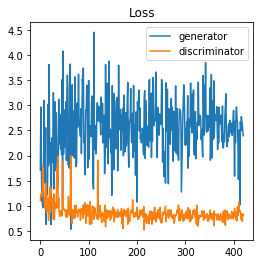


Took:  208.21432495117188  seconds
Epoch : 421 

batch: 0 - loss_d: 0.7123 - loss_g: 2.6990 - loss_real: 0.4871 - loss_fake: 0.2252
batch: 25 - loss_d: 0.6797 - loss_g: 3.0736 - loss_real: 0.4958 - loss_fake: 0.1839
batch: 50 - loss_d: 0.7818 - loss_g: 2.3483 - loss_real: 0.4926 - loss_fake: 0.2892
batch: 75 - loss_d: 0.7771 - loss_g: 2.4094 - loss_real: 0.4834 - loss_fake: 0.2936
batch: 100 - loss_d: 0.7330 - loss_g: 2.5471 - loss_real: 0.4970 - loss_fake: 0.2359
batch: 125 - loss_d: 0.8237 - loss_g: 2.5622 - loss_real: 0.5058 - loss_fake: 0.3179
batch: 150 - loss_d: 0.7700 - loss_g: 2.7425 - loss_real: 0.4637 - loss_fake: 0.3064
batch: 175 - loss_d: 0.8201 - loss_g: 3.3068 - loss_real: 0.5153 - loss_fake: 0.3049
batch: 200 - loss_d: 0.6888 - loss_g: 2.4851 - loss_real: 0.5022 - loss_fake: 0.1867
batch: 225 - loss_d: 0.7907 - loss_g: 2.3942 - loss_real: 0.4717 - loss_fake: 0.3190
batch: 250 - loss_d: 0.8493 - loss_g: 2.8374 - loss_real: 0.4512 - loss_fake: 0.3982
batch: 275 - loss_d:

KeyboardInterrupt: 

In [18]:
import time
torch.cuda.empty_cache()

num_epochs = 1000

for ep in range(0,num_epochs):

    start=time.time()
    print("Epoch :",ep,'\n')
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device, dtype=torch.float)
        
        # dont't forget to change the real labels for generator
        labels_fake = (((torch.rand(len(images))+1)/2)+0.2).to(device, dtype=torch.float) # labels  0.7 - 1.2   
        labels_real = ((torch.rand(len(images)))/3).to(device, dtype=torch.float)  # labels  0 - 0.3
    
        rnd_indexes = set(np.random.randint(len(images), size=int(0.05*len(images))))
        
        # flip the labels of 5% of the data for disciminator only
        for i in rnd_indexes:
            labels_real[i] = ((labels_real[i]+1)/2)+0.2
            labels_fake[i] = labels_fake[i]/3 - 0.1
            
        # Train the discriminator, it tries to discriminate between real and fake (generated) samples
        discriminator.zero_grad()
        outputs_re = discriminator(images)
        loss_real = criterion(outputs_re, labels_real)

        z = generate_latent_vector(len(images))
        images_fake = generator(z)
        outputs_fe = discriminator(images_fake.detach())
        loss_fake = criterion(outputs_fe, labels_fake)

        loss_d = loss_real + loss_fake              # Calculate the total loss
        loss_d.backward()                           # Backpropagation
        optimizer_d.step()                          # Update the weights

        # Train the generator, it tries to fool the discriminator
        # Draw samples from the input distribution and pass to generator
        z = generate_latent_vector(len(images))
        images_fake = generator(z)
        # Pass the genrated images to discriminator
        outputs_fe_gen = discriminator(images_fake)

        generator.zero_grad()
        
        labels_real = (torch.zeros(len(images))).to(device, dtype=torch.float) # hard labels for the generator with no noise
        loss_g = criterion(outputs_fe_gen, labels_real)    # Calculate the loss
        loss_g.backward()                                  # Backpropagation
        optimizer_g.step()                                 # Update the weights
     
        if n % (25) == 0:
            print('batch: {} - loss_d: {:.4f} - loss_g: {:.4f} - loss_real: {:.4f} - loss_fake: {:.4f}'.format
                  (n, loss_d.item(), loss_g.item(),loss_real.item(),loss_fake.item()))
    
    print('\nD_loss: {}; G_loss: {}'.format(loss_d.item(), loss_g.item()))

    # Save the test results after each Epoch
    torch.save(generator.state_dict(), snapshot_folder+'/model_gen_'+str(ep)+'.pth')
    torch.save(generator.state_dict(), snapshot_folder+'/model_dis_'+str(ep)+'.pth')

    test_name = test_folder+'/ep'+str(ep)+'.png'
    
    test = generator(generate_latent_vector(len(images)))[i]
    save_image((test+ 1) / 2.0, test_name)
    
    dis_loss.append(loss_d.item())
    gen_loss.append(loss_g.item())
    end= time.time()
    
    print('Lowest G loss:', min(gen_loss))
    
    if ep % 10 == 0:
        plt.figure(figsize=(4,4))
        plt.title('Loss')
        plt.plot(gen_loss)
        plt.plot(dis_loss)
        plt.legend(['generator','discriminator'])
        plt.show()

    print('\nTook: ', end-start, ' seconds')
    print('='*80)

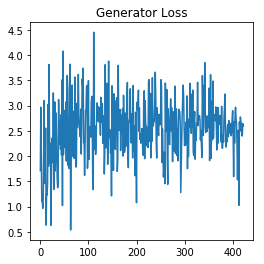

In [19]:
plt.figure(figsize=(4,4))
plt.title('Generator Loss')
plt.plot(gen_loss)
plt.show()

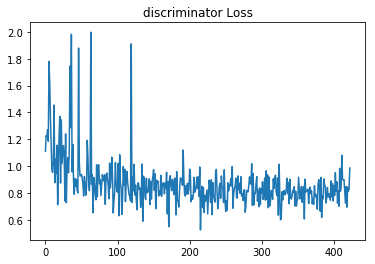

In [20]:
plt.title('discriminator Loss')
plt.plot(dis_loss)
plt.show()

In [21]:
minl=np.inf
for i,g in enumerate(gen_loss):
    if g<minl:
        minl=g
        minidx=i
minidx,minl

(63, 0.5382052063941956)